<a href="https://colab.research.google.com/github/drscook/PD4SDG/blob/master/main_v17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

v14
- Major refactoring of code to make new features work better with older ones
- Done hurriedly and still not test as thoroughly as I would like

v13
- Galton Board

v12 (The Nicholas Update)
- run now has sister function run_with_conditions(part,Walls,conds)
- Defined Conditional types:
- ShiftAccumulator(thresh_func) checks cell shift to see if it surpasses a threshold.
- DistAccumulator(thresh_func) does the same thing for total distance (cell_shift+pos)
- StepMax is the "ordinary condition" to be used whenever more complex conditions aren't needed. (run still works as normal.)

v11
- spin arrows
- shadows for prior collisions
- improved, more efficient phase portraits
- record phase during simulation in the following order: [vel normal, vel tangential, spin]
- many general code improvements

v10
- no interpolate for draw with no force
- fix memory crash for phase portraits

v9
phase portraits

v8
- handles complex (corner) collisions by slightly redirecting particle to avoid them.  Add complexity to the logic in next_state, but should be invisible to the user.  Report any bugs.
- Made it easier to use colab widgets
- sped up render static trajectory plot

v7
- force

v6 improvements
- no slip collisions

Major improvements from v3 to v5
- handles false collisions more efficiently
- animations
- wrap walls
- better cleanup
- export to json - easy to write to file if desired

# Main Code

In [0]:
import os
from abc import ABC, abstractmethod
import json
from copy import deepcopy
import itertools as it
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

import datetime
import pytz
cst = pytz.timezone('US/Central')
tol = 1e-8


####################################################################################################
### Helpers ###
####################################################################################################


class MyEncoder(json.JSONEncoder):
    """
    Custom JSON Encoder to cast numpy object to base python
    """
    def default(self, z):
        if isinstance(z, np.ndarray):
            return z.tolist()
        elif isinstance(z, np.int64):
            return int(z)
        return super().default(z)

def timestamp():
    return datetime.datetime.now(cst).strftime('%Y-%m-%d_%H-%M-%S')

def mag(v):
    return np.sqrt(v.T @ v)

def rotation_matrix(theta):
    return np.array([[np.cos(theta), -np.sin(theta)],
                     [np.sin(theta), np.cos(theta)]])


####################################################################################################
### Abstract Base Class ###
####################################################################################################


class AbstractBaseClass(ABC):
    #__getitem__ and __setitem__ allow you syntax choices.  Suppose you want to 
    # get or set an attribute named "kai".  You can now either use
    # part.kai or part["kai"].  Sometimes the second  is more convenient than
    # the first.  Without __get_item and __setitem__, we can only use the first one.
    def __getitem__(self, key):
        return self.__dict__[key]

    
    def __setitem__(self, key, val):
        self.__dict__[key] = val
    
    
    def __classname__(self):
        return self.__class__.__name__

    
    # Allows default parameters values from subclasses to roll up to base class
    def __init__(self, print_ignored=True, **kwargs):
        self.set_name()
        self.print_ignored = print_ignored
        if len(kwargs) > 0 and self.print_ignored:
            print(f'\nThe following given values were ignored while creating {self.name}')
            print(kwargs)
        self.print_ignored = False
    
    
    def setup(self):
        self.__init__(**self.__dict__)
    
    
    def set_name(self):
        self.name = self.__classname__()
    
    
    def param_error(self, var, msg="", null_ok=False):
        if null_ok and np.all(pd.isnull(self[var])):
            pass
        else:
            raise Exception(f"{var} = {self[var]} given for {self.name} - {msg}")

            
    def param_warning(self, var, msg=""):
        print(f"Warning: {var} = {self[var]} given for {self.name} - {msg}")

        
    def set_bool(self, var, val, null_ok=False):
        try:
            self[var] = val
            assert isinstance(self[var], bool)
        except:
            msg = f"must be boolean"
            self.param_error(var, msg, null_ok)

            
    def set_pos_int(self, var, val, null_ok=False):
        try:
            self[var] = val
            assert isinstance(self[var], int) and self[var] >= 0
        except:
            msg = f"must be positive integer"
            self.param_error(var, msg, null_ok)

            
    def set_pos_float(self, var, val, null_ok=False):
        try:
            self[var] = float(val)
            assert self[var] >= 0.0
        except:
            self[var] = val
            msg = f"must be positive float"
            self.param_error(var, msg, null_ok)

            
    def set_list(self, var, val, null_ok=False):
        try:
            self[var] = list(val)
            assert isinstance(self[var], list)
        except:
            self[var] = val
            msg = f"must be an iterable"
            self.param_error(var, msg, null_ok)

            
    def set_vec(self, var, val, dtype=float, null_ok=False):
        try:
            self[var] = np.asarray(val, dtype=dtype)
            assert len(self[var]) == self.dim
        except:
            self[var] = val
            msg = f"must have length dim={self.dim}"
            self.param_error(var, msg, null_ok)


####################################################################################################
### Particle Class ###
####################################################################################################


class Particle(AbstractBaseClass):
    def __init__(self, dim=2, step=0, steps_max=None, wall_idx=None,
                 radius=1.0, mass=1.0, gamma=1/np.sqrt(2), t=0.0, rot=0.0, drot=0.0, spin=0.0, arclength=None, phi=None, KE=None,
                 force=None, pos=None, pos_frame=None, cell_shift=(0.0, 0.0), vel=None, vel_frame=None, phase=None, phase_unit=None,
                 alive=True, stopping_conditions=(),
                 vars_to_record=('wall_idx', 't', 'pos', 'vel', 'rot', 'drot', 'cell_shift', 'arclength', 'phi', 'KE', 'phase_unit'),
                 **kwargs):
        super().__init__(**kwargs)
        
        for var in ['dim', 'step', 'steps_max', 'wall_idx']:
            self.set_pos_int(var, eval(var), null_ok=True)

        for var in ['radius', 'mass', 'gamma', 't', 'rot', 'drot', 'spin', 'arclength', 'phi', 'KE']:
            self.set_pos_float(var, eval(var), null_ok=True)

        for var in ['force', 'pos', 'pos_frame', 'cell_shift', 'vel', 'vel_frame', 'phase', 'phase_unit']:
            self.set_vec(var, eval(var), null_ok=True)

        for var in ['alive']:
            self.set_bool(var, eval(var), null_ok=True)
        
        for var in ['stopping_conditions', 'vars_to_record']:
            self.set_list(var, eval(var), null_ok=True)

        self.beta = 2 * np.arctan(self.gamma)
        w = self.gamma * self.radius
        if w > tol:
            self.spin_scale_factor = 1 / w
        else:
            self.spin_scale_factor = 0.0
        self.inertia = self.mass * (self.gamma * self.radius) ** 2
        g = 1 + self.gamma**2
        a = (1 - self.gamma**2) / g
        b = 2 * self.gamma / g
        self.no_slip_matrix = np.array([[-1, 0, 0],
                                        [ 0 ,a,-b],
                                        [ 0,-b,-a],
                                       ])
        self.get_bdy_pts()
        self.timestamp = timestamp()

        
    def setup(self):
        super().setup()
        try:
            self.accel = self.force / self.mass
            assert mag(self.accel) > tol
        except:
            self.force = None
            self.accel = 0.0

        if abs(self.drot) > tol:
            self.get_spin()
        else:
            self.get_drot()

        #Reset all Conditionals & create a StepsMax if there is not one already
        if not any([isinstance(cond, StepsMaxStoppingCondition) for cond in self.stopping_conditions]):
            try:
                self.stopping_conditions.append(StepsMaxStoppingCondition(self.steps_max))
            except:
                print('Warning - no steps_max stopping condition specified.  Could infinitely loop.')
        self.reset_history()


    def get_spin(self):
        if self.spin_scale_factor > tol:
            self.spin = self.drot / self.spin_scale_factor
        else:
            self.spin = 0.0
        
        
    def get_drot(self):
        self.drot = self.spin * self.spin_scale_factor

        
    def check_real_collision_get_arclength(self, Walls):
        """
        Because we allow parts of flat and circle walls but .get_dts detect collisions with missing
        parts, we check before applying the collision law where the collision is again
        is real or imaginary part of the wall.
        """
        arclengths = [wall.check_real_collision_get_arclength(self) for wall in Walls]  # run this method in each wall
        self.arclength = np.sum(arclengths)
        if self.arclength >= 0:
            self.real_collision = True
        else:
            self.real_collision = False
            self.arclength = np.nan
        return self.real_collision

    
    def get_bdy_pts(self):
        """
        Returns boundary points for plots
        """
        s = np.linspace(-np.pi, np.pi, 100)
        s = np.append(s, 0)  # appending 0 draws the equator line through center to show spin
        self.bdy_pts = self.radius * np.array([np.cos(s), np.sin(s)])
        return self.bdy_pts


    def reset_history(self):
        self['hist'] = {}
        for var in self.vars_to_record:
            self['hist'][var] = []


    def record_state(self):
        """
        Records states as simulation runs
        """
        for var in self['vars_to_record']:
            try:
                self['hist'][var].append(self[var].copy())  # write current value into hist; copy if possible
            except:
                self['hist'][var].append(self[var])


    def clean_up(self):
        """
        Final tasks after simulation complete
        """
        # Cast lists to numpy arrays and set dtype to float32 to save space
        for var in self['vars_to_record']:
            self['hist'][var] = np.asarray(self['hist'][var])


####################################################################################################
### Particle Class ###
####################################################################################################
            
            
# At each point on a wall, there is an orthonormal frame.
# We collect these as ROW vectors of a matrix frame with the normal on top.
# To transform from lab coords to frame coords, (matrix) multiply with frame.T on the right.
# To transform from frame coords to lab coords, (matrix) multiply with frame on the right.
class Wall(AbstractBaseClass):
    def __init__(self, wall_idx=None, dim=2, radius=1.0, base=(0.0, 0.0), north=(1.0, 0.0), cell_shift=(0.0, 0.0),
                 inside=True, outside=False, needs_caps=False, is_cap=False, hard=True, kill=False,
                 collision_law='specular', **kwargs):
        for var in ['wall_idx', 'dim']:
            self.set_pos_int(var, eval(var), null_ok=True)
        super().__init__(**kwargs)

        for var in ['radius']:
            self.set_pos_float(var, eval(var), null_ok=True)

        for var in ['base', 'north', 'cell_shift']:
            self.set_vec(var, eval(var), null_ok=True)

        for var in ['inside', 'outside', 'needs_caps', 'is_cap', 'hard', 'kill']:
            self.set_bool(var, eval(var), null_ok=True)
        
        self.collision_law = collision_law
        self.two_side = self.inside and self.outside

        self.north /= mag(self.north)
        self.west = np.array([-self.north[1], self.north[0]])
        self.axes = np.array([self.north, self.west])
        self.two_side = self.inside and self.outside

        
    def set_name(self):
        self.name = f"wall{self.wall_idx}-{self.__classname__()}"
   

    def setup(self, part):
        super().setup()
        if self.is_cap and self.needs_caps:
            msg = f"walls that are caps should not need caps.  Check for coding/logic error."
            self.param_error("needs_caps", msg)

        self.get_bdy_pts()
        self.assign_law()
        self.get_arclength(part)


    def get_caps(self):
        """
        The collision detection methods .get_dts of partial walls in interior of billiard cell
        can be fooled by nearly tangentially incoming particle trajectories.  We prevent
        this by placing hard half-circle caps of radius 0 at the walls endpoint.
        The vector between last 2 walls points is the first axes vector (north)."
        """
        bdy_pts = self.get_bdy_pts().T
        def f(base, north):
            return SphereWall(base=base, radius=2*tol, north=north, collision_law=self.collision_law,
                               max_polar_angle=np.pi/2+tol, hard=True, outside=True, inside=False,
                               is_cap=True, needs_caps=False)
        cap1 = f(bdy_pts[0] , bdy_pts[0] - bdy_pts[1])
        cap2 = f(bdy_pts[-1], bdy_pts[-1]- bdy_pts[-2])
        return [cap1, cap2]
    
        
    def specular_law(self, part, Walls):
        """
        Applies specular collision law v_out = v_in - 2*(v_in @ normal)normal.
        """
        n = self.get_frame(part)[0]
        part.vel -= 2 * (n @ part.vel) * n

        
    def no_slip_law(self, part, Walls):
        """
        Implements no-slip collision law
        """
        self.get_phase(part)
        part.phase = part.no_slip_matrix @ part.phase
        part.spin = part.phase[-1]
        part.vel_frame = part.phase[:-1]
        part.vel = part.vel_frame @ self.frame


    def wrap_law(self, part, Walls):
        """
        Applies wrap around law
        """
        # To make images look right, we must record state both before and after wrapping.
        # But we can't record arclength and phi both times - this would double count these collisions.
        # We will set both to nan and (re)compute them after we resolve the collision
        part.phi = np.nan
        part.arclength = np.nan
        part.record_state()

        old_wall_idx = self.wall_idx  # wall_idx that was hit and wrapping away from
        new_wall_idx = self.wrap_wall_idx  # wall_idx wrapping to
        old_wall = self
        new_wall = Walls[new_wall_idx]
        

        # Get frames for old and new walls
        frame_old = old_wall.get_frame_vars(part)
        frame_new = new_wall.get_frame_vars(part)
        
        # Compute new velocity
        part.vel_frame[0] *= -1  # flips normal coordinate so particle is moving toward correct side of new wall
        if self.flip_vel:
            part.vel_frame[1] *= -1  # optionally flips tangential coordinate in case old and new walls have tangents going in different directions
        part.vel = part.vel_frame @ frame_new # vel_new in standard coordinates
        
        # Compute new position
        part.pos_frame[0] *= -1  # flips normal coordinate so particle appears on correct side of new wall
        if self.flip_pos:
            part.pos_frame[1] *= -1  # optionally flips tangential coordinate in case old and new walls have tangents going in different directions
        part.pos = part.pos_frame @ frame_new + new_wall.base  # new part positions

        # record wrap
        part.cell_shift += old_wall.cell_shift
        part.wall_idx = new_wall_idx  
        part.check_real_collision_get_arclength(Walls)


    def assign_law(self):
        """
        Defines wall method "resolve_collision" for specified collision_law
        """
        if self.collision_law == "specular":
            self.resolve_collision = self.specular_law
        elif self.collision_law == 'no_slip':
            self.resolve_collision = self.no_slip_law
        elif self.collision_law == "wrap":
            if not isinstance(self, FlatWall):
                msg = f"wrap law only defined for FlatWall (currently)"
                self.param_error("collision_law", msg)
            self.set_pos_int('wrap_wall_idx', self.wrap_wall_idx)
            self.set_bool('flip_pos', self.flip_pos)
            self.set_bool('flip_vel', self.flip_vel)
            if self.hard:
                # Wrap_law should usually use a soft wall so particle center can reach the wall; otherwise it will jump.
                msg = f"particle will stop short of this wrap wall and appear to jump.  This is typically not desired."
                self.param_warning("hard", msg)
            self.resolve_collision = self.wrap_law
        else:
            msg = f"unknown collision law"
            self.param_error("collision_law", msg)


    def solver(self, coefs, ignore_smallest=False):
        coefs = np.array(coefs, dtype='float')
        if coefs.ndim < 2:
            coefs = coefs[np.newaxis]
        elif coefs.ndim > 2:
            raise Exception("coefs must be 2D array")

        roots = []
        for c in coefs:
            c = c.tolist()
            # remove all leading zeros
            deg = len(c)-1
            while abs(c[0]) < tol:
                c.pop(0)
                deg -= 1
                if deg < 1:
                    r = []
            if deg < 1:
                r = []
            elif deg == 1:  # linear
                r = [-c[1] / c[0]]
            elif deg == 2:  # quadratic
                d = c[1]**2 - 4*c[0]*c[2]
                if d < 0:  # complex
                    r = []
                else:  # real
                    u = -c[1] / (2*c[0])
                    v = np.sqrt(d) / (2*c[0])
                    r = [u+v, u-v]
            else:  # cubic or higher
                r = np.roots(c)
            roots.append(r)

        roots = np.hstack(roots)
        if len(roots) > 0:
            ## remove closest to zero if needed
            if ignore_smallest:
                idx = np.argmin(np.abs(roots))
                roots[idx] = np.inf

            ## remove non-real roots
            idx = np.abs(np.imag(roots)) > tol
            roots[idx] = np.inf
            roots = np.real(roots)

            ## remove negative roots
            idx = roots < 0
            roots[idx] = np.inf
        return roots

    def get_frame_vars(self, part):
        """
        Returns [normal, tangential] component of position and velocity in the walls frame
        """
        self.get_frame(part)
        dx = part.pos - self.base
        part.pos_frame = dx @ self.frame.T
        part.vel_frame = part.vel @ self.frame.T
        return self.frame
        

    def get_phase(self, part):
        """
        Returns [normal, tangential, spin] phase vectors in unscaled as in unit forms
        """
        self.get_frame_vars(part)
        part.phase = np.append(part.vel_frame, part.spin)
        part.phi = np.arctan2(-part.vel_frame[1], -part.vel_frame[0])
        part.KE = mag(part.phase)
        part.phase_unit = part.phase / part.KE
        return self.frame


    @abstractmethod
    def get_arclength(self, part):
        pass

    @abstractmethod
    def get_frame(self, part):
        pass

    @abstractmethod
    def get_dts(self, part):
        pass

    @abstractmethod
    def check_real_collision_get_arclength(self, part):
        pass

    @abstractmethod
    def get_bdy_pts(self):
        pass
    
    
    
class FlatWall(Wall):
    def __init__(self, wrap_wall_idx=None, flip_pos=None, flip_vel=None, **kwargs):
        super().__init__(**kwargs)
        self.set_pos_int('wrap_wall_idx', wrap_wall_idx, null_ok=True)
        self.set_bool('flip_pos', flip_pos, null_ok=True)
        self.set_bool('flip_vel', flip_vel, null_ok=True)

        
    def setup(self, part):
        super().setup(part)            
        if self.two_side and not self.needs_caps:
            msg = f"two-sided flat wall usually needs caps"
            self.param_warning("needs_caps", msg)

        
    def get_arclength(self, part):
        if self.inside:
            self.inside_arclength = 2 * self.radius
        else:
            self.inside_arclength = 0.0

        if self.outside:
            self.outside_arclength = 2 * self.radius
        else:
            self.outside_arclength = 0.0
        self.total_arclength = self.inside_arclength + self.outside_arclength
            

    def get_frame(self, part):
        """
        Since flat wall has the same frame everywhere, get_normal simply returns that frame.
        Recall that the no_slip law expects the "outward" normal which points toward the other side of the wall from where the particle is.
        This happens if dx@F[0] is negative.  In this case, flip the frame.
        """
        self.frame = self.axes.copy()
        dx = part.pos - self.base
        if dx @ self.frame[0] > tol:  # normal points toward particle - must flip
            self.frame *= -1
        return self.frame


    def get_dts(self, part):
        """
        Finds time(s) when particle would next hit this wall.
        """
        if part.force is None:
            c0 = 0.0
        else:
            c0 = part.accel/2 @ self.north
        c1 = part.vel @ self.north  # normal component of vel
        dx = part.pos - self.base  # vector from base of wall to center of particle
        c2 = dx @ self.north  # normal component of dx
        r = part.radius * self.hard  # if hard, make a band of width part.radius around wall.  If soft, do not.
        if r > tol:
            coefs = [[c0, c1, c2-r], [c0, c1, c2+r]]
        else:
            coefs = [c0, c1, c2]

        ignore_smallest = (self.wall_idx == part.wall_idx)
        self.dt = self.solver(coefs, ignore_smallest)
        return self.dt

                
    def check_real_collision_get_arclength(self, part):
        """
        Checks if collision is against removed portion of wall & compute arclength position
        """
        if self.wall_idx < part.wall_idx:  # if particle hits a different wall with bigger wall_idx, count my entire arclength
            s = self.total_arclength
        elif self.wall_idx > part.wall_idx:  # if particle hits a different wall with smallerbigger wall_idx, count none of my arclength
            s = 0.0
        else:  # if particle hits me, compute how much arclength to count
            self.get_frame_vars(part)
            if np.abs(part.pos_frame[1]) > self.radius:  # if tangential component of dx is bigger than my radius, it hit a removed part.  Its not a real collision.
                s = -np.inf  # return -inf so part.check_real... knows I determined this is not a real collision.
            else:
                s = part.pos_frame[1] + self.radius  # shifts so arclength is 0 to total_arclength; had been -radius to +radius
                # if two sided, the side with negative normal dx is 0 to total_arclength/2 and collision had positive normal dx
                # and the side with positive normal dx is total_arclength/2 to total_arclength
                if part.pos_frame[0] >= 0: # particle on outside
                    s += self.inside_arclength
        return s
    
    
    def get_bdy_pts(self):
        """
        Returns boundary points for plots
        """
        s = np.linspace(-self.radius, self.radius, 100)
        self.bdy_pts = (self.base + self.axes[1] * s[:,np.newaxis]).T
        return self.bdy_pts
        

class SphereWall(Wall):
    def __init__(self, max_polar_angle=np.pi+tol, **kwargs):
        super().__init__(**kwargs)
        self.set_pos_float('max_polar_angle', max_polar_angle)
        
        if not self.is_cap:
            if self.max_polar_angle < np.pi:
                if not self.needs_caps:
                    msg = f"walls with max polar angle = {self.max_polar_angle:.2f} < pi=3.14 must have caps.  Changing needs_caps to True."
                    self.param_warning("needs_caps", msg)
                    self.needs_caps = True
            else:
                self.max_polar_angle = np.pi + tol
                if self.needs_caps:
                    msg = f"walls with max polar angle = np.pi do not need have caps.  Changing needs_caps to False."
                    self.param_warning("needs_caps", msg)
                    self.needs_caps = False
        self.min_polar_projection = np.cos(self.max_polar_angle)
        self.hole_radius = self.radius * np.sin(np.pi - self.max_polar_angle)  # radius of hole create by missing part of sphere
        

    def setup(self, part):
        super().setup(part)            
        if self.hole_radius < part.radius:
            if self.radius < part.radius and self.inside:
                msg = f"wall radius {self.radius} < particle radius = {part.radius}.  Particle can not fit inside wall.  Changing inside to False."
                self.param_warning("inside", msg)
                self.inside = False
            elif self.two_side:
                msg = f"hole radius {self.hole_radius} < particle radius = {part.radius}.  Particle can not fit through the hole, but wall is set as two_sided.  This is okay, but inefficient.  Please consider specifying inside or outside as False."
                self.param_warning("two_side", msg)
        elif not self.two_side:
            msg = f"hole radius {self.hole_radius} > particle radius = {part.radius}.  Wall must be changed to two-sided."
            self.param_warning("two_side", msg)
            self.inside   = True
            self.outside  = True
        super().setup(part)
                
        
    def get_arclength(self, part):
        if self.inside:
            self.inside_arclength = 2 * self.max_polar_angle * (self.radius - part.radius * self.hard)
        else:
            self.inside_arclength = 0.0

        if self.outside:
            self.outside_arclength = 2 * self.max_polar_angle * (self.radius + part.radius * self.hard)
        else:
            self.outside_arclength = 0.0
        self.total_arclength = self.inside_arclength + self.outside_arclength
    
    
    def get_frame(self, part):
        """
        Frame depends on collision point and must be computed at each step.  Get normal vector and then extend to frame.
        Recall that the no_slip law expects the "outward" normal which points toward the other side of the wall from where the particle is.
        Note that n=part.pos-self.base gives a normal vector pointing from circle center to particle.
        If particle is inside of circle, this normal is an "outward" pointing normal.  So the frame is correct.
        If particle is outside of circle,  this normal is an "inward"  pointing normal.  So the frame is must be flipped.
        """
        n = part.pos - self.base
        m = mag(n)
        n /= m
        t = [-n[1], n[0]]
        self.frame = np.array([n, t])
        if m > self.radius + tol:  # particle outside, normal must point in
            self.frame *= -1
        return self.frame

    
    def get_dts(self, part):
        """
        Finds time(s) when particle would next hit this wall.
        Let Collision occurs when |part.pos - self.base|^2 = (self.radius +- part.radius)^2.
        Write part.pos(t) = part.pos(0) + t * part.vel.  Gives a quadratic whose zeros are dt's.
        """
        dx = part.pos - self.base  # vector from circle center to particle center
        v = part.vel
        if part.force is None:
            c0 = 0.0
            c1 = 0.0
            c2 = v @ v  # particle speed ^ 2
        else:
            a = part.accel / 2
            c0 = a @ a
            c1 = 2 * a @ v
            c2 = v @ v + 2 * a @ dx
        c3 = 2 * v @ dx
        c4 = dx @ dx
        R = self.radius
        r = part.radius * self.hard  # if hard, make concentric circles inside and outside wall by part.radius; if soft do not
        coefs_inside  = [c0, c1, c2, c3, c4-(R-r)**2]
        coefs_outside = [c0, c1, c2, c3, c4-(R+r)**2]
        if self.two_side:
            coefs = [coefs_inside, coefs_outside]
        else:
            if self.inside:
                coefs = coefs_inside
            elif self.outside:
                coefs = coefs_outside
            else:
                raise Exception("Wall has both inside and outside equal False")
        ignore_smallest = (self.wall_idx == part.wall_idx)
        self.dt = self.solver(coefs, ignore_smallest)
        return self.dt

    
    def check_real_collision_get_arclength(self, part):
        """
        Checks if collision is against removed portion of wall & compute arclength position
        """
        if self.wall_idx < part.wall_idx:  # if particle hits a different wall with bigger wall_idx, count my entire arclength
            s = self.total_arclength
        elif self.wall_idx > part.wall_idx:  # if particle hits a different wall with smallerbigger wall_idx, count none of my arclength
            s = 0.0
        else:  # if particle hits me, compute how much arclength to count
            dx = part.pos - self.base
            m = mag(dx)  # distance from part center to wall center
            dx /= m  # unit vector from part center to wall center
            pos_axes = dx @ self.axes.T  # dx relative to axes
            if pos_axes[0] < self.min_polar_projection:  # if polar projection is less than min_polar_projection, this is not a real collision
                s = -np.inf
            else:
                polar_angle = np.arctan2(pos_axes[1], pos_axes[0])
                assert abs(polar_angle) < self.max_polar_angle
                theta = polar_angle + self.max_polar_angle  #shift from +/- max _polar_angle to [0, 2*max_polar_angle]

                if m < self.radius + tol:  # inside of circle
                    s = theta * (self.radius - part.radius * self.hard)
                else:  #outside of circle
                    s = theta * (self.radius + part.radius * self.hard)
                    s+= self.inside_arclength
        return s
        

    def get_bdy_pts(self):
        """
        Returns boundary points for plots
        """
        s = np.linspace(-self.max_polar_angle, self.max_polar_angle, 100)
        self.bdy_pts = np.array([np.cos(s), np.sin(s)]) * self.radius
        self.bdy_pts = self.axes.T @ self.bdy_pts
        self.bdy_pts += self.base[:,np.newaxis]
        return self.bdy_pts


####################################################################################################
### Stopping Condition Class ###
####################################################################################################
            
            
class StoppingCondition(AbstractBaseClass):
    def __init__(self, kill_func):
        self.kill_func = kill_func
        self.triggered = False

    def check(self, part, Walls):
        self.triggered = self.kill_func(part, Walls)
        return not self.triggered


class StepsMaxStoppingCondition(StoppingCondition):
    def __init__(self, steps_max):
        self.steps_max = int(steps_max)
        def kill_func(part, Walls):
            return part.step >= self.steps_max
        super().__init__(kill_func)


class FloorStoppingCondition(StoppingCondition):
    def __init__(self, floor):
        def kill_func(part, Walls):
            return (part.cell_shift[1] + part.pos[1]) - floor < tol
        super().__init__(kill_func)


class DistanceStoppingCondition(StoppingCondition):
    def __init__(self, distance_max):
        def kill_func(part, Walls):
            return mag(part.cell_shift + part.pos) - distance_max > tol
        super().__init__(kill_func)


####################################################################################################
### Cell Class ###
####################################################################################################
            
            
class Cell(AbstractBaseClass):
    def __init__(self, dim=2, Walls=(), center=(0.0, 0.0), collision_law='specular', **kwargs):
        super().__init__(**kwargs)
        self.set_pos_int('dim', dim)
        self.set_list('Walls', Walls)
        self.set_vec('center', center)
        self.collision_law = collision_law
        

        
class PolygonCell(Cell):
    def __init__(self, sides=6, radius_inscribed=1/np.sqrt(3), **kwargs):
        super().__init__(**kwargs)
        self.set_pos_int('sides', sides)
        self.set_pos_float('radius_inscribed', radius_inscribed)
        
        self.side_length = np.tan(np.pi / self.sides) * self.radius_inscribed
        for i, theta in enumerate(np.linspace(0, 2*np.pi, self.sides, endpoint=False)):
            north = np.array([np.cos(theta), np.sin(theta)])
            base = north * self.radius_inscribed + self.center
            params = {'wall_idx':len(self.Walls), 'dim':2, 'radius':self.side_length,
                      'base':base, 'north':north, 'cell_shift':2*north,
                      'inside':True, 'outside':False, 'kill':False, 'needs_caps':False, 'is_cap':False,
                      'collision_law':self.collision_law}
            if self.collision_law == 'wrap':
                if not self.sides % 2 == 0:
                    msg = f"sides must be even to use wrap law"
                    self.param_error("sides", msg)
                offset = int(sides / 2)
                params['wrap_wall_idx'] = (i + offset) % sides
                params['hard'] = False
                params['flip_pos'] = True
                params['flip_vel'] = True
            else:
                params['hard'] = True
            self.Walls.append(FlatWall(**params))    

            
            

class PolygonWithScattererCell(PolygonCell):
    def __init__(self, scatterer_radius=1.0, scatterer_max_polar_angle=np.pi, scatterer_north=[0.0, 1.0], 
                 scatterer_inside=False, scatterer_outside=True, scatterer_collision_law='specular', **kwargs):
        super().__init__(**kwargs)
        self.set_pos_float('scatterer_radius', scatterer_radius)
        self.set_pos_float('scatterer_max_polar_angle', scatterer_max_polar_angle)
        self.set_vec('scatterer_north', scatterer_north)
        self.set_bool('scatterer_inside', scatterer_inside)
        self.set_bool('scatterer_outside', scatterer_outside)
        self.scatterer_collision_law = scatterer_collision_law
        

        params = {'wall_idx':len(self.Walls), 'dim':2, 'radius':self.scatterer_radius,
                  'base':self.center, 'north':self.scatterer_north, 'cell_shift':[0.0, 0.0],
                  'inside':self.scatterer_inside, 'outside':self.scatterer_outside, 'kill':False, 'needs_caps':False, 'is_cap':False,
                  'collision_law':self.scatterer_collision_law, 'max_polar_angle':self.scatterer_max_polar_angle}
        self.Walls.append(SphereWall(**params))


class LorentzCell(PolygonWithScattererCell):
    def __init__(self, a=0.5, b=0.5, collision_law='wrap', **kwargs):
        kwargs['dim'] = 2
        kwargs['collision_law'] = collision_law
        kwargs['sides'] = 6
        kwargs['radius_inscribed'] = 1 / np.sqrt(3)
        
        self.a = float(a)
        if not tol < self.a < 1 - tol:
            msg = f"must be btw 0 and 1"
            self.param_error("a", msg)
        kwargs['scatterer_radius'] = kwargs['radius_inscribed'] * self.a
        super().__init__(**kwargs)
        
        self.b = float(b)
        b_low  = -2 / np.sqrt(3) 
        b_high = (1 - self.a) / (1 - np.sqrt(3) / 2)
        if not b_low < self.b < b_high:
            msg = f"must be btw -2/sqrt(3) = {b_low} and (1 - a) / (1 - sqrt(3) / 2) = {b_high}"
            self.param_error("b", msg)
        self.set_pos_float('particle_radius', self.radius_inscribed * (self.b * (np.sqrt(3) / 2 - self.a) + (1 - self.a) * (1 - self.b)))


class SinaiCell(PolygonWithScattererCell):
    def __init__(self, a=0.5, b=0.5, collision_law='wrap', **kwargs):
        kwargs['dim'] = 2
        kwargs['collision_law'] = collision_law
        kwargs['sides'] = 4
        kwargs['radius_inscribed'] = 1.0

        self.a = float(a)
        if not tol < self.a < 1 - tol:
            msg = f"must be btw 0 and 1"
            self.param_error("a", msg)
        kwargs['scatterer_radius'] = kwargs['radius_inscribed'] * self.a / np.sqrt(2)
        super().__init__(**kwargs)
        
        self.b = float(b)
        b_low  = 0.0
        b_high = (np.sqrt(2) - self.a) / (np.sqrt(2) - 1)
        if not b_low < self.b < b_high:
            msg = f"must be btw 0.0 and (sqrt(2) - a) / (sqrt(2) - 1) = {b_high}"
            self.param_error("b", msg)
        self.set_pos_float('particle_radius', self.radius_inscribed * (np.sqrt(2) - self.a + b * (1 - np.sqrt(2))) / np.sqrt(2))


####################################################################################################
### Evolution ###
####################################################################################################
            
            
def next_state(part, Walls):
    """
    Evolve system one step
    """
    # A complex collision involves multiple walls (corner).  We can not resolve them.
    # We check for them and avoid them by slightly redirecting the particle.
    # Specifically, we rotate the velocity slightly in the normal direction at the
    # point of last collision.
    
    # A false collision occurs on a removed portion of a wall.
    # For example, a half circle behaves like a full circle when finding DT.
    # We move the particle forward and check if the collision occurred on missing part.
    # If so, move the particle back, set the associated entry in DT to np.inf, and try again.
    
    # get dts from each wall; each wall may return 0, 1, or many.  M = most dt's reported by a single wall
    complex_collision = True
    while complex_collision:
        L = [len(wall.get_dts(part)) for wall in Walls]  # computes dts at each wall and records how many dts each wall reports
        N = max(L)  # most dts reported by a single wall
        M = len(Walls)  # number of wall
        part.DT = np.full(shape=(M,N), fill_value=np.inf)  # MxN array to hold dts
        for i, l in enumerate(L):
            part.DT[i, :l] = Walls[i].dt  # write dt's from wall i into row i
        part.DT[part.DT < 0] = np.inf  # set any negative's to np.inf
    
        # attempt to move using the smallest dt and check if its complex or false collision.
        # If complex, rotate the velocity and start next_state again (recompute DT).
        # If false, move back where it started, set that entry of DT to np.inf, and try again.
        # Note we do NOT need to recompute DT to handle false collisions - just find
        # the next smallest positive DT (after setting the prior to np.inf) and try again.
        
        false_collision = True
        while false_collision:
            part.dt = np.min(part.DT)
            assert not np.isinf(part.dt), f"No more collisions detected - particle escaped the chamber at step {part.step}"
            where_dt = np.abs(part.DT - part.dt) < tol
            num_col = np.sum(where_dt)
            if num_col == 1:
                complex_collision = False            
                row, col = np.unravel_index(part.DT.argmin(), part.DT.shape)  # What slot contains the smallest positive time
                part.wall_idx = row
                next_wall = Walls[row]

                # Move particle
                dx = part.vel * part.dt
                if part.force is not None:
                    dx += part.accel / 2 * part.dt**2
                part.pos += dx

                # check if this is a real or false collision (false = against part of wall that has been removed)
                if part.check_real_collision_get_arclength(Walls):  # if real collision, great!  We found next collision.  Compute things and resolve the collision.
                    false_collision = False
                    part.t += part.dt
                    if part.force is not None:
                        part.vel += part.accel * part.dt
                    part.rot += part.drot * part.dt
                    part.rot %= 2 * np.pi
                    
                    next_wall.resolve_collision(part, Walls)
                    part.get_drot()
                    next_wall.get_phase(part)
                    
                    part.alive = not next_wall.kill
                    break
                else:  # if not real collision, move the particle back and try again with next smallest dt
                    false_collision = True
                    part.pos -= dx
                    part.DT[row, col] = np.inf
            else:
                print(f"Complex collision detected at step {part.step}.  Redirecting particle slightly to avoid it.")
                complex_collision = True
                old_wall = Walls[part.wall_idx]
                frame = old_wall.get_frame_vars(part)
                
                s = np.sign(part.vel_frame[0])
                adjust = True
                while adjust:
                    theta = (np.random.rand()*2-1) * np.pi / 2 * 0.05
                    vf = part.vel_frame.copy() @ rotation_matrix(theta)
                    adjust = np.sign(vf[0]) != s
                part.vel_frame = vf
                part.vel = part.vel_frame @ frame
                break

    return part, Walls


def run(part, Walls):
    """
    Run the system
    """
    # Preliminaries
    part.wall_bdy_pts = []
    Caps = []
    for i, wall in enumerate(Walls):
        Walls[i].wall_idx = i
        wall.setup(part)
        if wall.needs_caps:
            Caps.extend(wall.get_caps())
        part.wall_bdy_pts.append(wall.get_bdy_pts())
    Walls.extend(Caps)

    for i, wall in enumerate(Walls):  # Relabel b/c caps were added
        Walls[i].wall_idx = i
        wall.setup(part)

    part.setup()
    part.record_state()

    ## Run it
    while part.alive:
        part.step += 1
#         print(f"step {part.step}")
        
        part, Walls = next_state(part, Walls)  # evolves the system forward one step
        part.record_state()
        part.alive &= all([cond.check(part, Walls) for cond in part.stopping_conditions])
        
           
    part.clean_up()
    return part, Walls

In [0]:
#@title Cook's Graphics Code (double-click to open) { display-mode: "form" }
## Graphics

from IPython.display import HTML
import io
import base64
import matplotlib.pyplot as plt
from matplotlib import animation, rc
%matplotlib inline

def accum(dx):
    dx_cum = np.cumsum(dx)
    dx_cum = np.insert(dx_cum, 0, 0)
    dx = np.append(dx, 0)
    return dx_cum, dx

def diff_accum(x):
    dx = np.abs(np.diff(x))
    return accum(dx)

def interpolate(part_orig, frames=100, smoothing=60, frames_per_step='variable'):
    """
    Interpolates between collision events to make a smooth animation
    """
    part = deepcopy(part_orig) 
    hist = part['hist']
    interp = {}
    
    
    frames = max(frames, 1)
    steps_max = len(hist['t'])-1
    dx = np.linalg.norm(np.diff(hist['pos'], axis=0), axis=1)
    dx_cum, dx = accum(dx)
    
    L = np.full_like(part.pos, fill_value=np.nan)
    U = L.copy()
    for w in part['wall_bdy_pts']:
        l = np.min(w, axis=1)
        L = np.fmin(L, l)

        u = np.max(w, axis=1)
        U = np.fmax(U, u)
    dx_flight_max = mag(U-L)

    if isinstance(frames_per_step, int):
        frames_per_step = max(frames_per_step, 2)
        steps = int(np.floor(frames / frames_per_step))

        steps = min(steps_max, steps)
        hist['t'], hist['dt'] = diff_accum(hist['t'][:steps+1])

        frames_per_step = np.full(steps, fill_value=frames_per_step)
    else:
        dx_flight_frame_max = dx_flight_max / smoothing  # sets max dist particle can move in a single frame
        dx_cum_max = dx_flight_frame_max * frames  # total distance particle can possibly move in the specified number of frame given max_frame_flight
        
        keep_steps = dx_cum < dx_cum_max
        steps = np.sum(keep_steps)

        steps = min(steps_max, steps)
        hist['t'], hist['dt'] = diff_accum(hist['t'][:steps+1])
        
        dt_frame_ave = hist['t'][-1] / frames  # ave "experiment" time during each frame
        frames_per_step = np.ceil(hist['dt'][:-1] / dt_frame_ave)
        frames_per_step[frames_per_step < 1] = 1

    hist['frame'], hist['dframe'] = accum(frames_per_step.astype(int))
    hist['dframe'][-1] = 1
    hist['dt_frame'] = hist['dt'] / hist['dframe']

    def expand(x):
        return np.repeat(x, hist['dframe'], axis=0)  # repeats the value for each interpolated frame we are making

    vars_to_interpolate = ['t', 'pos', 'vel', 'rot', 'drot']
    for var in vars_to_interpolate:
        interp[var] = expand(hist[var][:steps+1])

    if part['force'] is None:
        a = 0.0
    else:
        a = part['accel']
    interp['accel'] = np.broadcast_to(a, interp['vel'].shape)

    dt_in_step = np.concatenate([dt * np.arange(f) for dt, f in zip(hist['dt_frame'], hist['dframe'])])
    interp['t']   += dt_in_step
    interp['dt']   = np.abs(np.diff(interp['t']))
    interp['rot'] += interp['drot'] * dt_in_step
    interp['rot']  = np.moveaxis([[np.cos(interp['rot']), -np.sin(interp['rot'])],
                                 [np.sin(interp['rot']), np.cos(interp['rot'])]]
                                , -1, 0)
        
    dt_in_step = dt_in_step[:,np.newaxis]
    interp['pos'] += interp['vel']   * dt_in_step + interp['accel'] / 2 * dt_in_step**2 
    interp['vel'] += interp['accel'] * dt_in_step


    ## trails
    long_frames = interp['dt'] > tol
    interp['trail_t'] = []
    interp['trail'] = []
    for i, long in enumerate(long_frames):
        if long:
            interp['trail_t'].append(interp['t'][i+1])
            interp['trail'].append(interp['pos'][i:i+2])
    interp['trail_t'] = np.array(interp['trail_t'])
    interp['trail']   = np.array(interp['trail'])

    
    ## arrows
    t_mid = hist['t'] + hist['dt'] / 2
    long_steps = hist['dt'] > tol
    t_mid = t_mid[long_steps]

    s = np.subtract.outer(interp['t'], t_mid)
    s[s < -tol] = np.inf
    v = np.argmin(s, axis=0)

    arrow_mid  = interp['pos'][v]
    arrow_shaft = interp['vel'][v]
    arrow_shaft /= (np.linalg.norm(arrow_shaft, axis=1, keepdims=True))
    arrow_shaft *= dx_flight_max / 50
    arrow_tail  = arrow_mid - arrow_shaft
    arrow_head  = arrow_mid + arrow_shaft
    interp['arrow'] = np.stack([arrow_tail, arrow_head], axis=1)
    interp['arrow_t'] = interp['t'][v]
    
    part['hist']   = hist
    part['interp'] = interp
    return part


def height_to_arclength(radius, height):
    return radius * (np.pi/3 - np.arcsin((np.sqrt(3) - height / radius) / 2))


def arclength_to_height(radius, arclength):
    return radius * (np.sqrt(3) - 2 * np.sin(np.pi / 3 - arclength / radius))


def make_head(axis=np.array([0.0, 1.0]), base=np.zeros(2), max_height=np.inf, max_width=np.inf, max_arclength=np.inf, radius=None):
    """
    Make arrow heads
    """
    assert ~(np.isinf(max_width) & np.isinf(max_height) & np.isinf(max_arclength)), "must specify at least one of max_width, max_length, max_arclength"
    
    height = min(max_height, max_width * np.sqrt(3))
    if (radius is not None) & (not np.isinf(max_arclength)):
        height = min(height, arclength_to_height(radius, max_arclength))
    
    width = height / np.sqrt(3)
    data = {'height':height, 'width':width}
    if radius is not None:
        data['arclength'] = height_to_arclength(radius, height)
        data['angle'] = data['arclength'] / radius

    axis = axis / mag(axis) * height
    perp = np.array([-axis[1], axis[0]]) / np.sqrt(3)
    head = np.array([perp, axis, -perp, perp])
    head += base
    return head.T, data


def draw_part(part, frame=None):
    """
    Draw particle with linear and angular velocity vectors
    """
    interp = part['interp']
    
    bdy_pts = part.get_bdy_pts()
    if frame is None:
        frame = len(interp['t'])-1
    frame = int(min(frame, len(interp['t'])-1))

    interp = part['interp']
    pos  = interp['pos'][frame]
    vel  = interp['vel'][frame]
    rot  = interp['rot'][frame]
    drot = interp['drot'][frame]
    
    a = 0.7
    if part['radius'] > tol:
        spin_arrow_shaft_radius = part['radius'] * a

        da = 0.5
        spin_arrow_head_width_max = part['radius'] * (1 - a) * da

        b = 0.7
        spin_arrow_angle_max = np.pi * b
        total_arclength = spin_arrow_angle_max * spin_arrow_shaft_radius

        #spin arrow
        spin_KE_prop = drot**2 / (vel @ vel + drot**2)
        spin_arrow_arclength = total_arclength * spin_KE_prop
        spin_arrow_angle = spin_arrow_arclength / spin_arrow_shaft_radius

        head, head_data = make_head(max_width=spin_arrow_head_width_max, radius=part["radius"])
        db = 0.5
        spin_shaft_angle = max(spin_arrow_angle - head_data['angle'], 0) + np.pi * (1 - b) * db
    
        s = np.linspace(0, spin_shaft_angle, 20)
        shaft = spin_arrow_shaft_radius * np.array([np.cos(s), np.sin(s)])
    
        base = shaft[:,-1]
        axis = np.array([-base[1], base[0]])
        head, data = make_head(axis, base, max_width=spin_arrow_head_width_max)

        spin_arrow = np.concatenate([shaft, head], axis=1)
        reverse_spin_arrow = spin_arrow[:,::-1]
        pts = np.concatenate([reverse_spin_arrow, bdy_pts], axis=1)
    else:
        total_arclength = 1
        spin_arrow_head_width_max = total_arclength * (1-a)
        spin_arrow_arclength = 0
        pts = bdy_pts

    if drot < 0:
        pts[1] *= -1
    pts = rot @ pts


    # velocity arrow
    vel_arrow_arclength  = total_arclength - spin_arrow_arclength
    axis = vel / mag(vel) 
    head, head_data = make_head(axis=vel, max_width=spin_arrow_head_width_max)
    
    shaft = np.array([[0,0], axis * (max(vel_arrow_arclength - head_data['height'], 0) + part['radius'] / a)]).T
    head += shaft[:,[-1]]
    vel_arrow = np.concatenate([shaft, head], axis=1)
    
    pts = np.concatenate([pts, vel_arrow], axis=1) + pos[:,np.newaxis]
    return pts


def draw(part_orig, steps=None, ax=None, color='blue', show_trail=True, show_arrows=True, show_past=True):
    """
    Draw the system
    """
    if steps is None or steps < 0:
        steps = 100

    if part_orig['force'] is None:
        frames_per_step = 2
    else:
        frames_per_step = 10
    frames = steps * frames_per_step + 1

    part   = interpolate(part_orig, frames=frames, frames_per_step=frames_per_step)
    hist   = part['hist']
    interp = part['interp']
    steps  = len(hist['t'])
    frames = len(interp['t'])

    # Get last state
    t   = interp['t'][-1] + tol
    pos = interp['pos'][-1]
    vel = interp['vel'][-1]
    rot = interp['rot'][-1]

    if ax is None:   # May pass in ax to overlay plots
        fig, ax = plt.subplots(figsize=(5,5))
        ax.set_aspect('equal')  # If unequal aspect, collisions may not look right
        ax.grid(False)

    # Draw walls
    for bdy in part['wall_bdy_pts']:
        ax.plot(*bdy, 'k', linewidth=2.0)

    # Draw particle
    bdy_pts = draw_part(part)
    bdy = ax.plot(*bdy_pts, color=color, linewidth=1.5, alpha=1.0)[0]

    if steps > 0:
        # We record steps against wrap walls twice so that the trails looked right.
        # We must not draw trails for the "teleportation" through the walls.
        # We detect them by looking for dt very close to 0.
        if show_trail:
            idx = interp['trail_t'] < t
            for tr in interp['trail'][idx]:
                ax.plot(*tr.T, color=color, linewidth=1.2)

        if steps < 100:
            if show_arrows:  # This got harder with curved trajectories
                idx = interp['arrow_t'] < t
                for tail, head in interp['arrow'][idx]:
                    ax.annotate("", xy=head, xytext=tail, arrowprops=dict(facecolor='black'))
                    
            if show_past:
                idx = (hist['frame'] < frames) & (hist['dt'] > tol)
                for f in hist['frame'][idx]:
                    bdy_pts = draw_part(part, f)
                    bdy = ax.plot(*bdy_pts, color=color, linewidth=1.5, alpha=0.2)[0]
    return ax, part


def embed_video(fname):
    """
    Embed .mp4 movie into Jupyter Notebook
    """
    video = io.open(fname, 'r+b').read()
    encoded = base64.b64encode(video)

    display(HTML(data='''<video alt="test" controls>
         <source src="data:video/mp4;base64,{0}" type="video/mp4" />
         </video>'''.format(encoded.decode('ascii'))))

    
def animate(part_orig, movie_time=5, frames_per_second=30, smoothing=80, color='blue', show_trail=True, show_arrows=False, show_past=True, save=True, embed=True):
    """
    Create animation
    """
    frames = movie_time * frames_per_second
    
    print(f"I will attempt to animate {frames} frames")
    
    #interpolate the data
    part   = interpolate(part_orig, frames, smoothing)
    hist   = part['hist']
    interp = part['interp']
    steps  = len(hist['t'])
    frames = len(interp['t'])
    
    # See Draw function for descriptions
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set_facecolor('w')
    
    # Draw walls
    for bdy in part['wall_bdy_pts']:
        ax.plot(*bdy, 'k', linewidth=2.0)

    # Show experiment time
    time_text = ax.text(0.02, 0.98, '', transform=ax.transAxes)

    # Draw particle
    bdy = ax.plot([], [], color=color, linewidth=1.5)[0]
    
    # Draw all trails, but make them invisible initially.
    # We will make them appear at the appropriate moment within the update function
    trail = []
    if show_trail:
        for tr in interp['trail']:
            trail.append(ax.plot(*tr.T, color=color, linewidth=1.2, animated=True, visible=False)[0])

    past = []
    past_t = []
    if show_past:
        idx = hist['dt'] > tol
        interp['past_t'] = hist['t'][idx]
        for f in hist['frame'][idx]:
            bdy_pts = draw_part(part, f)
            past.append(ax.plot(*bdy_pts, color=color, linewidth=1.5, alpha=0.2, animated=True, visible=False)[0])

    # Draw all arrows, but make them invisible initially.
    # We will make them appear at the appropriate moment within the update function
    arrows = []
    if show_arrows:
        for tail, head in interp['arrow']:
            arrows.append(ax.annotate("", xy=head, xytext=tail, arrowprops=dict(facecolor='black'), animated=True, visible=False))

    def init():
        time_text.set_text('')
        bdy.set_data(draw_part(part, 0))
        return [bdy] + trail + arrows

    def update(s):
        t = interp['t'][s] + tol
        time_text.set_text(f"time {t:.2f}")  # run timer
        bdy.set_data(draw_part(part, s))

        if show_trail:  # make eariler trails appear
            idx = interp['trail_t'] < t
            if np.any(idx):
                i = np.argmin(idx) - 1
                trail[i].set_visible(True)

        if show_arrows:
            idx = interp['arrow_t'] < t
            if np.any(idx):
                i = np.argmin(idx) - 1
                arrows[i].set_visible(True)

        if show_past:
            idx = interp['past_t'] < t
            if np.any(idx):
                i = np.argmin(idx) - 1
                past[i].set_visible(True)

        return [bdy] + trail + arrows + past

    anim = animation.FuncAnimation(fig, update, init_func=init,
                                   frames=frames, interval=movie_time*1000/frames, 
                                   blit=True)
    plt.close()

    if save:
        os.makedirs(part['save_path'], exist_ok=True)
        anim_file = part['save_path'] + 'animation.mp4'
        print(anim_file)
        anim.save(filename=anim_file)  # save animation as mp4
        if embed:
            embed_video(anim_file)    # show in notebook - resizing issues
    elif embed:
        display(HTML(anim.to_jshtml()))        # diplays video in notebook

    return anim, part


0.5 3.7 0.2886751345948129 0.002479138593197383 0.002479138593197383


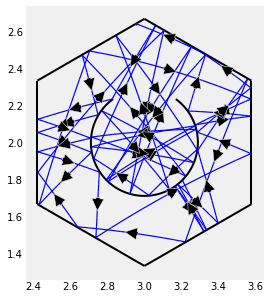

In [0]:
center = [3.0, 2.0]

cell = LorentzCell(b=3.7, collision_law='specular', scatterer_collision_law='specular', center=center,
                 scatterer_max_polar_angle=np.pi*0.8, scatterer_north=[0.0, -1.0], scatterer_inside=True)
Walls = cell.Walls

part = Particle()
part.radius = cell.particle_radius
part.force = [0.0, -1.0]
part.steps_max = 10000


start_wall_idx = -1
start_wall = Walls[start_wall_idx]
part.wall_idx = start_wall.wall_idx
part.pos = start_wall.base + (part.radius + start_wall.radius) * (start_wall.north + start_wall.west) / np.sqrt(2)
part.vel = start_wall.west + 2*start_wall.north
part.spin = 2.5

part, Walls = run(part, Walls)
# print(f"Ran for {part.step} steps")
# # part.save_run()

ax, part_draw = draw(part, steps=50, show_arrows=True, show_trail=True, show_past=True)
plt.show()

anim, part_anim = animate(part, movie_time=15, frames_per_second=30, smoothing=50,
                          save=False, embed=True, show_arrows=True, show_trail=True, show_past=True)

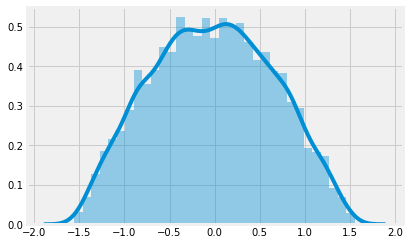

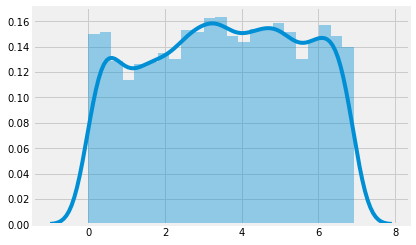

6.91747970373388


,in,out,tot,cum
0,0.666667,0.000000,0.666667,0.666667
1,0.666667,0.000000,0.666667,1.333333
2,0.666667,0.000000,0.666667,2.000000
3,0.666667,0.000000,0.666667,2.666667
4,0.666667,0.000000,0.666667,3.333333
5,0.666667,0.000000,0.666667,4.000000
6,1.438578,1.463501,2.902079,6.902079
7,0.000000,0.007789,0.007789,6.909867
8,0.000000,0.007789,0.007789,6.917656


0.007788443591619832

In [0]:
dt = np.abs(np.diff(part['hist']['t']))
idx = dt > tol
idx = np.append(idx, True)
idx[0] = False
l = part['hist']['phi'][idx]
sns.distplot(l)
plt.show()



l = part['hist']['arclength'][idx]
sns.distplot(l)
plt.show()
print(l.max())





# print(np.cumsum([w.total_arclength for w in Walls]))
# np.cumsum([w.total_arclength for w in Walls])
      
L = [[w.inside_arclength, w.outside_arclength, w.total_arclength] for w in Walls]
df = pd.DataFrame(L, columns=['in','out','tot'])
df['cum'] = np.cumsum(df['tot'])

display(df)

part.radius*np.pi

In [0]:
dt = np.abs(np.diff(part['hist']['t']))
idx = dt > tol
idx = np.append(idx, True)
idx[0] = False
l = part['hist']['phi'][idx]
l
z = part['hist']['pos'][idx] + part['hist']['cell_shift'][idx]
mag = np.linalg.norm(z, axis=1)
mag.shape
mask = mag < Walls[-3].radius - tol


In [0]:
part['hist']['cell_shift']

array([None, None, None, ..., None, None, None], dtype=object)

In [0]:
class Cell(AbstractBaseClass):
    def __init__(self, dim=2, Walls=(), center=(0.0, 0.0), collision_law='specular', **kwargs):
        super().__init__(**kwargs)
        self.set_pos_int('dim', dim)
        self.set_list('Walls', Walls)
        self.set_vec('center', center)
        self.collision_law = collision_law

        
class PolygonCell(Cell):
    def __init__(self, sides=6, radius_inscribed=1/np.sqrt(3), **kwargs):
        super().__init__(**kwargs)
        self.set_pos_int('sides', sides)
        self.set_pos_float('radius_inscribed', radius_inscribed)
        
        self.side_length = np.tan(np.pi / self.sides) * self.radius_inscribed
        for i, theta in enumerate(np.linspace(0, 2*np.pi, self.sides, endpoint=False)):
            north = np.array([np.cos(theta), np.sin(theta)])
            base = north * self.radius_inscribed + self.center
            params = {'dim':2, 'wall_idx':len(self.Walls), 'radius':self.side_length, 'base':base, 'north':north, 'cell_shift':2*north,
                      'inside':True, 'outside':False, 'needs_caps':False, 'is_cap':False,
                      'collision_law':self.collision_law, 'kill':False}
            if self.collision_law == 'wrap':
                if not self.sides % 2 == 0:
                    msg = f"sides must be even to use wrap law"
                    self.param_error("sides", msg)
                offset = int(sides / 2)
                params['wrap_wall_idx'] = (i + offset) % sides
                params['hard'] = False
                params['flip_pos'] = True
                params['flip_vel'] = True
            else:
                params['hard'] = True
            self.Walls.append(FlatWall(**params))    


class PolygonWithScattererCell(Poly)
            
class LorentzCell(PolygonCell):
    def __init__(self, a=0.5, b=0.5, scatterer_max_polar_angle=np.pi, scatterer_collision_law='specular', **kwargs):
        kwargs['sides'] = 6
        kwargs['radius_inscribed'] = 1 / np.sqrt(3)
        kwargs['collision_law'] = 'wrap'
        super().__init__(**kwargs)
        
        self.a = float(a)
        if not tol < self.a < 1 - tol:
            msg = f"must be btw 0 and 1"
            self.param_error("a", msg)
            
        self.b = float(b)
        b_low  = -2 / np.sqrt(3) 
        b_high = (1 - self.a) / (1 - np.sqrt(3) / 2)
        if not b_low < self.b < b_high:
            msg = f"must be btw -2/sqrt(3) = {b_low} and (1 - a) / (1 - sqrt(3) / 2) = {b_high}"
            self.param_error("b", msg)
            
        self.set_pos_float('scatterer_radius', self.a * self.side_length)
        self.set_pos_float( 'particle_radius', (self.b * (np.sqrt(3) / 2 - self.a) + (1 - self.b) * (1 - self.a)) * self.side_length)
        self.set_pos_float('scatterer_max_polar_angle', scatterer_max_polar_angle)
        self.scatterer_collision_law = scatterer_collision_law
        
        params = {'dim':2, 'wall_idx':len(self.Walls), 'radius':self.scatterer_radius, 'base':self.center, 'north':[0.0, 0.1],
                  'cell_shift':[0.0, 0.0], 'inside':False, 'outside':True, 'needs_caps':False, 'is_cap':False,
                  'collision_law':self.scatterer_collision_law, 'kill':False, 'max_polar_angle':self.scatterer_max_polar_angle}

        self.Walls.append(SphereWall(**params))
        

center = [3.0, 2.0]
radius_inscribed = 10#1/np.sqrt(3)
law = 'no_slip'
# Walls = make_polygon(center=center, radius_inscribed=radius_inscribed, collision_law=law)
# cell = PolygonCell(sides=6, center=center, radius_inscribed=radius_inscribed, collision_law=law)
#sides=6, center=center, radius_inscribed=radius_inscribed, collision_law=law)

# cell = LorentzCell(sides=4)
cell = PolygonCell(sides=4)
Walls = cell.Walls

cell.particle_radius = 0.1

part = Particle(force=[0.0,-1], steps_max=5, radius=cell.particle_radius)

start_wall_idx = 0
part.wall_idx = start_wall_idx
start_wall = Walls[start_wall_idx]

part.pos = start_wall.base - start_wall.north * part.radius
part.vel = start_wall.west - start_wall.north
part.spin = 0.5

part, Walls = run(part, Walls)
print(f"Ran for {part.step} steps")
# part.save_run()

ax, part_draw = draw(part, steps=500, show_arrows=True, show_trail=True, show_past=True)
plt.show()

anim, part_anim = animate(part, movie_time=5, frames_per_second=30, smoothing=50,
                          save=False, embed=True, show_arrows=True, show_trail=True, show_past=True)


In [0]:
vars(cell)

In [0]:
def make_polygon(sides=6, center=[0.0, 0.0], radius_inscribed=1/np.sqrt(3), collision_law='specular', Walls=()):
    Walls = list(Walls)
    center = np.asarray(center, dtype=float)
    length = np.tan(np.pi / sides) * radius_inscribed
    for i, theta in enumerate(np.linspace(0, 2*np.pi, sides, endpoint=False)):
        n = np.array([np.cos(theta), np.sin(theta)])
        b = n * radius_inscribed + center
        params = {'base':b, 'north':n, 'radius':length, 'inside':True, 'outside':False, 'collision_law':collision_law, 'wall_idx':len(Walls)}
        if collision_law == 'wrap':
            assert sides % 2 == 0, "I only know how to wrap with an even number of sides"
            offset = int(sides / 2)
            params['wrap_wall_idx'] = (i + offset) % sides
            params['hard'] = False
            params['flip_pos'] = True
            params['flip_vel'] = True
        else:
            params['hard'] = True
        Walls.append(FlatWall(**params))    
    return Walls

def make_Lorentz(center=[0.0, 0.0], collision_law=specular, Walls=()):
    


center = [3.0, 2.0]
radius_inscribed = 10#1/np.sqrt(3)
law = 'wrap'
Walls = make_polygon(center=center, radius_inscribed=radius_inscribed, collision_law=law)

part = Particle(radius=radius_inscribed*0.1, force=[0.0,-1], steps_max=5)

start_wall_idx = 0
part.wall_idx = start_wall_idx
start_wall = Walls[start_wall_idx]

part.pos = start_wall.base - start_wall.north * part.radius
part.vel = start_wall.west - start_wall.north
part.spin = 0.5

part, Walls = run(part, Walls)
print(f"Ran for {part.step} steps")
# part.save_run()

ax, part_draw = draw(part, steps=500, show_arrows=True, show_trail=True, show_past=True)
plt.show()

anim, part_anim = animate(part, movie_time=10, frames_per_second=30, smoothing=50,
                          save=False, embed=True, show_arrows=True, show_trail=True, show_past=True)


In [0]:
## Wrap Law
np.seterr(all='raise')  # stops program when "warnings" occur.  Default is to continue, but this option makes debugging easier
np.random.seed(5)  # produces the same thing every thing - easier for debugging

steps = 100
dim = 2

polygon_sides = 6
polygon_radius_inscribed = 10
assert polygon_sides % 2 == 0, "I only know how to wrap with an even number of sides"
offset = int(polygon_sides / 2)


######### Make particle #########
part = Particle(radius=2.0, force=[0.0,-0.01])

law = 'specular'
######### Make walls #########
Walls = []

# length = np.tan(np.pi / polygon_sides) * polygon_radius_inscribed
# for i, theta in enumerate(np.linspace(0, 2*np.pi, polygon_sides, endpoint=False)):
#     n = np.array([np.cos(theta), np.sin(theta)])
#     b = n * polygon_radius_inscribed
#     wrap_wall_idx = (i + offset) % polygon_sides
#     new_wall = FlatWall(base=b, north=n, radius=length, collision_law='wrap',
#                         hard=False, inside=True, outside=False,
#                         wrap_wall_idx=wrap_wall_idx, flip_pos=True, flip_vel=True)
#     Walls.append(new_wall)

length = np.tan(np.pi / polygon_sides) * polygon_radius_inscribed
for i, theta in enumerate(np.linspace(0, 2*np.pi, polygon_sides, endpoint=False)):
    n = np.array([np.cos(theta), np.sin(theta)])
    b = n * polygon_radius_inscribed
    wrap_wall_idx = (i + offset) % polygon_sides
    new_wall = FlatWall(base=b, north=n, radius=length, collision_law='wrap',
                        hard=False, inside=True, outside=False, wall_idx=len(Walls),
                        wrap_wall_idx=wrap_wall_idx, flip_pos=True, flip_vel=True
                       )
    Walls.append(new_wall)

    
    

scatterer_radius = 3.0
law = 'specular'

assert (scatterer_radius < polygon_radius_inscribed), "scatterer won't fit in the polygon"  # checks that the scatterer fits
new_wall = SphereWall(base=[0.0, -1.0], radius=scatterer_radius, wall_idx=len(Walls),
                      max_polar_angle = np.pi*0.3, inside=False, outside=True,
#                       max_polar_angle = np.pi*0.7, inside=False, outside=True,
                      north=[0,-1], collision_law='no_slip',)
Walls.append(new_wall)

new_wall = FlatWall(base=[-3.0,3.5], north=[0,1], radius=1.0, inside=True, outside=True, collision_law='no_slip',
                    wall_idx=len(Walls), needs_caps=True)
Walls.append(new_wall)


# new_wall = FlatWall(base=[3.0,3.51], north=[0,1], radius=1.0, inside=True, outside=True, collision_law=law)
# Walls.append(new_wall)


######### Initialize Particle #########
start_wall_idx = 0
part.wall_idx = start_wall_idx
start_wall = Walls[start_wall_idx]
part.pos = start_wall.base - start_wall.north * part.radius
# part.vel = part.vel = np.array([-2.02, -1.0])
part.vel = part.vel = np.array([-0.02, -1.0])
part.spin = 0.5
part.steps_max = 20


part, Walls = run(part, Walls)
print(f"Ran for {part.step} steps")
# part.save_run()

ax, part_draw = draw(part, steps=500, show_arrows=True, show_trail=True, show_past=True)
plt.show()

# ax, part_draw = draw(part, steps=1000, show_trail=True)
# plt.show()

# ######### Animate #########
anim, part_anim = animate(part, movie_time=10, frames_per_second=30, smoothing=50,
                          save=False, embed=True, show_arrows=True, show_trail=True, show_past=True)


In [0]:
print(part.force)

In [0]:
dt = np.abs(np.diff(part['hist']['t']))
idx = dt > tol
idx = np.append(idx, True)
idx[0] = False
l = part['hist']['arclength'][idx]
sns.distplot(l)
l.max()

In [0]:
q = [w['total_arclength'] for w in Walls]
np.cumsum(q)

In [0]:
w = Walls[6]
i = 2 * w.max_polar_angle * (w.radius - part.radius)
print(i, w.inside_arclength)
o = 2 * w.max_polar_angle * (w.radius + part.radius)
print(o, w.outside_arclength)
print(i+o, w.total_arclength)

# ['outside_arclength']

In [0]:
dt = np.abs(np.diff(part['hist']['t']))
idx = dt > tol
idx = np.append(idx, True)
idx[0] = False

idx2 = ~np.isnan(part['hist']['arclength'])
np.all(idx == idx2)
# len(idx)

In [0]:
part_anim['interp']['arrow_t']

In [0]:
def f(a=[]):
    a.append(3)
    print(a)
    
f()
f()

In [0]:
stopping_conditions

In [0]:
class Cell(AbstractBaseClass):
    def __init__(self, params_default_child={}, **params_specified):
        params_default = {'dim':2, 'base':[0.0,0.0]}
        params_default.update(params_default_child)
        super().__init__(params_default, **params_specified)
        
        self.base = np.asarray(self.base, dtype='float')
        assert len(self.base) == self.dim, "length of base must equal dim"
        
        self.Walls = []

        
class ChannelCell(Cell):
    def __init__(self, params_default_child={}, **params_specified):
        params_default = {'width':5.0, 'length':10., 'axis':[1.0, 0.0], 'collision_law':'specular'}
        params_default.update(params_default_child)
        super().__init__(params_default, **params_specified)
        
        self.axis = np.asarray(self.axis, dtype='float')
        self.axis /= mag(self.axis)
        self.transverse = np.array([-self.axis[1], self.axis[0]])
        
        params = self.__dict__.copy()
        params['inside'] = True
        params['outside'] = False
        params['kill'] = False
        params['hard'] = True
        params['radius'] = self.width
        
        params['north'] = -self.transverse
        params['base'] = self.base + self.width * params['north']
        print(params)
        self.Walls.append(FlatWall(**params))
        
        params['north'] = self.transverse
        params['base'] = self.base + self.width * params['north']
        print(params)
        self.Walls.append(FlatWall(**params))
        
        params['hard'] = False
        params['radius'] = self.length
        params['collision_law'] = 'wrap'
        params['flip_pos'] = True
        params['flip_vel'] = True

        params['north'] = -self.axis
        params['base'] = self.base + self.length * params['north']
        params['wrap_wall_idx'] = 3
        self.Walls.append(FlatWall(**params))

        params['north'] = self.axis
        params['base'] = self.base + self.length * params['north']
        params['wrap_wall_idx'] = 2
        self.Walls.append(FlatWall(**params))

        
class PolygonalCell(Cell):
    def __init__(self, params_default_child={}, **params_specified):
        params_default = {'sides':6, 'radius_inscribed':1 / np.sqrt(3), 'collision_law':'wrap'}
        params_default.update(params_default_child)
        super().__init__(params_default, **params_specified)
        
        assert self.radius_inscribed > tol, "radius_inscribed must be positive"
        
        self.length = np.tan(np.pi / self.sides) * self.radius_inscribed
        for i, theta in enumerate(np.linspace(0, 2*np.pi, self.sides, endpoint=False)):
            n = np.array([np.cos(theta), np.sin(theta)])
            b = n * self.radius_inscribed + self.base
            
            params = self.__dict__.copy()
            params['base'] = b
            params['north'] = n
            params['radius'] = self.length
            params['cell_shift'] = 2*b
            params['inside'] = True
            params['outside'] = False
            params['kill'] = False

            if self.collision_law == 'wrap':
                assert self.sides % 2 == 0, "I only know how to wrap with an even number of sides"
                offset = int(self.sides / 2)
                params['hard'] = False
                params['wrap_wall_idx'] = (i + offset) % self.sides
                params['flip_pos'] = True
                params['flip_vel'] = True
            else:
                params['hard'] = True
                params['wrap_wall_idx'] = None
                params['flip_pos'] = None
                params['flip_vel'] = None
                

            self.Walls.append(FlatWall(**params))

        
class PolygonalCellWithScatterer(PolygonalCell):
    def __init__(self, params_default_child={}, **params_specified):
        params_default = {'north':[0.0, 1.0], 'scatterer_radius':1 / np.sqrt(3) * 0.1,
                          'max_polar_angle':np.pi, 'scatterer_collision_law':'specular'}
        params_default.update(params_default_child)
        super().__init__(params_default, **params_specified)
        
        assert tol < self.scatterer_radius < self.radius_inscribed, "scatterer_radius must be btw 0 and polygon inscribed radius"

        scatterer_params = self.__dict__.copy()
        scatterer_params['radius'] = scatterer_params.pop('scatterer_radius')
        scatterer_params['collision_law'] = scatterer_params.pop('scatterer_collision_law')
        scatterer_params['hard'] = True
        scatterer_params['inside'] = False
        scatterer_params['outside'] = True
        self.Walls.append(SphereWall(**scatterer_params))
        
        
class LorentzCell(PolygonalCellWithScatterer):
    def __init__(self, params_default_child={}, **params_specified):
        params_default = {'sides':6, 'a':0.5, 'b':0.5, 'collision_law':'wrap', 'scatterer_collision_law':'specular'}
        params_default.update(params_default_child)
        
        super().__init__(params_default, **params_specified)
        
        R = self.radius_inscribed
        self.scatterer_radius = self.a * R
        self.particle_radius = (self.b * (np.sqrt(3) / 2 - self.a) + (1 - self.b) * (1 - self.a)) * R
        self.Walls[-1].radius = self.scatterer_radius
        print(f'adjusting scatterer radius to {self.scatterer_radius}')
        
        assert tol < self.a < 1-tol, "a must be between 0 and 1"
        b_low =  -2 / np.sqrt(3)
        b_up  = (1 - self.a) / (1 - np.sqrt(3) / 2)
        if self.b < b_low + tol:
            raise Exception(f'b must be greater than -2 / sqrt(3) = {b_low}')
        elif self.b < 0:
            self.horizon = 'trapped'
        elif self.b < 1:
            self.horizon = 'finite'
        elif self.b < b_up - tol:
            self.horizon = 'infinite'
        else:
            raise Exception(f'b must be less than (1-a)/(1-sqrt(3)/2) = {b_up}')


class LorentzGas(AbstractBaseClass):
    def __init__(self, params_default_child={}, **params_specified):
        params_default = {'a':0.5, 'b':0.85, 'force':None, 'boundary_radius':10.0,
                          'scatterer_collision_law':'no_slip', 'steps_max':None,
                         }
        params_default.update(params_default_child)
        super().__init__(params_default, **params_specified)

    def setup(self):
        cell = LorentzCell(**self.__dict__)
        part = Particle(radius=cell.particle_radius, **self.__dict__)
        part.save_path = f"{os.getcwd()}/{timestamp()}/"

        def check_hit_boundary(part, Walls):
            x = part['cell_shift'] + part['pos']
            return mag(x) > self.boundary_radius
        stopping_conditions = [StoppingCondition(kill_func=check_hit_boundary)]
        
        if self.steps_max is not None:
            stopping_conditions.append(StepsMaxStoppingCondition(self.steps_max))

        rnd = (np.random.rand(2) * 2 - 1).tolist()
        part.spin = rnd.pop() * 1.0
        part.pos = np.array([0.0, (cell.scatterer_radius + cell.particle_radius) * 1.1 ])
        part.vel = np.array([rnd.pop() * 0.1, -0.1])

        return part, cell, stopping_conditions

In [0]:
exp = LorentzGas(steps_max=1000, b=1.95, mass=1.0)
part, cell, stopping_conditions = exp.setup()
######### Run trial #########
part, cell = run(part, cell, stopping_conditions)#, steps_max)
print(f"Ran for {len(part['hist']['t'])} steps")
# part.save_run()

ax, part_draw = draw(part)
plt.show()

# ######### Animate #########
anim, part_anim = animate(part, movie_time=15, frames_per_second=30, save=True, embed=True)


In [0]:
ax, part_draw = draw(part)
plt.show()

# anim, part_anim = animate(part, movie_time=15, frames_per_second=30, save=False, embed=True)

In [0]:
cell = PolygonalCell(collision_law='no_slip', sides=4, radius_inscribed=100)
part = Particle(radius=0.1)

rnd = (np.random.rand(2) * 2 - 1).tolist()
part.spin = rnd.pop() * 0.01
part.pos = np.array([0.0, 0.0])
part.vel = np.array([rnd.pop() * 0.1, -0.1])


part, cell.Walls = run(part, cell.Walls, steps_max=100)



# exp = LorentzGas(steps_max=1000, b=1.95, mass=1.0)
# part, cell, stopping_conditions = exp.setup()
# ######### Run trial #########
# part, cell = run(part, cell, stopping_conditions)#, steps_max)
# print(f"Ran for {len(part['hist']['t'])} steps")
# # part.save_run()

# ax, part_draw = draw(part)
# plt.show()

# # ######### Animate #########
# anim, part_anim = animate(part, movie_time=15, frames_per_second=30, save=True, embed=True)


In [0]:
draw

In [0]:
part['hist']['wall_idx']
print(part['hist']['wall_idx'])
print(part['hist']['pos'])
print(part['hist']['vel'])

In [0]:
ax, part_draw = draw(part, show_arrows=False, show_trail=False, show_past=False)
plt.show()

In [0]:
for w in cell.Walls:
    print()
    print(w.base)
#     print(w.north)
    print(w.axes)
    print(w.radius)

In [0]:
exp = LorentzGas(steps_max=1000, b=1.95, mass=1.0)
part, cell, stopping_conditions = exp.setup()
######### Run trial #########
part, cell = run(part, cell, stopping_conditions)#, steps_max)
print(f"Ran for {len(part['hist']['t'])} steps")
# part.save_run()

ax, part_draw = draw(part)
plt.show()

# ######### Animate #########
anim, part_anim = animate(part, movie_time=15, frames_per_second=30, save=True, embed=True)




# param_options = {'a': [0.5],
#                  'b': [0.5],
#                  'gamma': [1/np.sqrt(2)],#np.linspace(0.0, 1/np.sqrt(2), 4).tolist() + [1.0],
#                  'force': [[0.0, -1.0]],
#                  'collision_law': ['specular'],#, 'no_slip'],
#                  'boundary_radius': [10],
#                 }
# param_product = it.product(*param_options.values())
# experiments = [dict(zip(param_options.keys(), param_values)) for param_values in param_product]

# ######### Run the experiments #########
# trials = 5
# vars_to_record = ['t', 'pos', 'cell_shift']
# records = []
# run_timestamp = timestamp()
# # run_path = f"{os.{run_timestamp}\
# run_path = f"{os.getcwd()}/{run_timestamp()}/"
# for exp_idx, exp_params in enumerate(experiments):
# #     new_record = {var:[] for var in vars_to_record}
# #     new_record.update(exp_params)
# #     new_record['timestamp'] = run_timestamp
# #     new_record['run_path'] = run_path
# #     new_record['exp_path'] = f"{run_path}/{exp_idx}/"

#     new_record = exp_params.copy()
#     new_record['timestamp'] = run_timestamp
#     new_record['run_path'] = run_path
#     new_record['exp_path'] = f"{run_path}/{exp_idx}/"
#     new_record['trial']

#     print(f"\n\nRunning Lorentz Gas")
#     print(exp)
#     for trial in range(trials):
#         part, Walls = Lorentz_gas_with_boundary(**exp, report_progress=True)

In [0]:
for w in cell.Walls:
    print(w.collision_law)

In [0]:
print(part['hist']['drot'][:10,np.newaxis])
# print(part['hist']['spin'][:10])
print(part['hist']['vel'][:10])
print(part['hist']['wall_idx'][:10])

In [0]:
part.radius

In [0]:


    def extend_frame(A):
        """
        An overly fancy method to extend a set of ROW vectors to an orthonormal frame.
        Recall that and orthonormal frame must contain exactly self.dim many vectors
        that are mutually orthogonal and unit length.

        If no vectors are supplied, returns standards unit vectors along axes.
        If one or more vectors are supplied, applies QR-factorization to:
        1. make supplied vectors mutually orthogonal and unit length
        2. generate additional vectors that are orthogonal and unit length if fewer than
        self.dim many vectors were supplied.
        """

        A = np.asarray(A)
        if A.ndim == 0:
            return np.eye(self.dim)
        elif A.ndim == 1:
            A = A[np.newaxis,:]  # make into 2D-array
        print(A.shape)

        # Though we store vectors are ROWS of A, np.linalg.qr wants them as columns.
        # So we tranpose if nrows <= ncols
        m, n = A.shape
        if m > n:  
            A = A.T
            m, n = n, m

        # The heavy lifting to apply QR-factorization.
        # Flag 'complete' asks np.linalg.qr to generate additional vectors if necessary.
        F = np.linalg.qr(A.T, 'complete')[0].T

        # np.linalg.qr might flip the sign of vectors supplied in A.  We flip them back.
        s = np.sign(np.diag(A@F.T))
        F[:m] *= s

        return F

In [0]:
t = parrecords[0]['t']
z = records[0]['pos'] + records[0]['cell_shift']
# print(t.shape)
plt.plot(t, z[0,:,0], '.')
plt.plot(t, z[0,:,1], '.')
plt.show()

In [0]:
# plt.plot(part['hist']['t'], part['hist']['pos'][:,1], '.')
plt.plot(part_draw['interp']['pos'][:,0], part_draw['interp']['pos'][:,1], '.')
part_draw['hist']['pos'].shape

In [0]:
part.hist

In [0]:
class Cell(AbstractBaseClass):
    def __init__(self, params_default_child={}, **params_specified):
        params_default = {'dim':2, 'base':[0.0,0.0]}
        params_default.update(params_default_child)
        super().__init__(params_default, **params_specified)
        
        self.base = np.asarray(self.base, dtype='float')
        assert len(self.base) == self.dim, "length of base must equal dim"
        
        self.Walls = []

class PolygonalCell(Cell):
    def __init__(self, params_default_child={}, **params_specified):
        params_default = {'sides':6, 'radius_inscribed':1 / np.sqrt(3), 'collision_law':'wrap'}
        params_default.update(params_default_child)
        super().__init__(params_default, **params_specified)
        
        assert self.radius_inscribed > tol, "radius_inscribed must be positive"
        
        self.length = np.tan(np.pi / self.sides) * self.radius_inscribed
        for i, theta in enumerate(np.linspace(0, 2*np.pi, self.sides, endpoint=False)):
            print(i)
            n = np.array([np.cos(theta), np.sin(theta)])
            b = n * self.radius_inscribed + self.base
            
            params = self.__dict__.copy()
            params['base'] = b
            params['north'] = n
            params['radius'] = self.length
            params['cell_shift'] = 2*b
            params['inside'] = True
            params['outside'] = False
            params['kill'] = False

            if self.collision_law == 'wrap':
                assert self.sides % 2 == 0, "I only know how to wrap with an even number of sides"
                offset = int(self.sides / 2)
                params['hard'] = False
                params['wrap_wall_idx'] = (i + offset) % self.sides
                params['flip_pos'] = True
                params['flip_vel'] = True
            else:
                params['hard'] = True
                params['wrap_wall_idx'] = None
                params['flip_pos'] = None
                params['flip_vel'] = None
                

            self.Walls.append(FlatWall(**params))

        
class PolygonalCellWithScatterer(PolygonalCell):
    def __init__(self, params_default_child={}, **params_specified):
        params_default = {'north':[0.0, 1.0], 'scatterer_radius':1 / np.sqrt(3) * 0.1,
                          'max_polar_angle':np.pi, 'scatterer_collision_law':'specular'}
        params_default.update(params_default_child)
        super().__init__(params_default, **params_specified)
        
        assert tol < self.scatterer_radius < self.radius_inscribed, "scatterer_radius must be btw 0 and polygon inscribed radius"

        scatterer_params = self.__dict__.copy()
        scatterer_params['radius'] = scatterer_params.pop('scatterer_radius')
        scatterer_params['collision_law'] = scatterer_params.pop('scatterer_collision_law')
        self.Walls.append(SphereWall(**scatterer_params))
        
        
class LorentzGas(PolygonalCellWithScatterer):
    def __init__(self, params_default_child={}, **params_specified):
        params_default = {'sides':6, 'a':0.5, 'b':0.5, 'collision_law':'wrap', 'scatterer_collision_law':'specular'}
        params_default.update(params_default_child)
        super().__init__(params_default, **params_specified)
        
        assert tol < self.a < 1-tol, "a must be between 0 and 1"
        b_low =  -2 / np.sqrt(3)
        b_up  = (1 - self.a) / (1 - np.sqrt(3) / 2)
        if self.b < b_low + tol:
            raise Exception(f'b must be greater than -2 / sqrt(3) = {b_low}')
        elif self.b < 0:
            self.horizon = 'trapped'
        elif self.b < 1:
            self.horizon = 'finite'
        elif self.b < b_up - tol:
            self.horizon = 'infinite'
        else:
            raise Exception(f'b must be less than (1-a)/(1-sqrt(3)/2) = {b_up}')
            
        self.scatterer_radius = self.a * self.radius_inscribed
        self.particle_radius = (self.b * (np.sqrt(3) / 2 - self.a) + (1 - self.b) * (1 - self.a)) * self.radius_inscribed
            
        params = self.__dict__.copy()
#         params['sides'] = 6
#         params_cell['scatterer_collision_law'] = params_cell.pop('scatterer_collision_law')
            
#         params_cell = {'sides':6, 'radius_inscribed':1 / np.sqrt(3), 'collision_law':'wrap',
#                       'scatterer_radius':self.scatterer_radius}
            
        self.cell = PolygonalCellWithScatterer(**params)
#         self.part = Particle(**self.__dict__)

    
            
#         params = {'dim':2, 'sides':6, 'radius_inscribed':self.radius_inscribed, 'collision_law':'wrap',
#                   'scatterer_radius': self.a * self.radius_inscribed,
#                   'particle_radius': (self.b * (np.sqrt(3) / 2 - self.a) + (1 - self.b) * (1 - self.a)) * self.radius_inscribed
#                  }
        
#         self.cell = PolygonalCellWithScatterer(**params)
        
#         self.part = Particle()#dim=2, mass=mass, radius=particle_radius, gamma=gamma,
#                         force=force)



# cell = PolygonalCellWithScatterer(collision_law='specular')
cell = LorentzGas(a=0.7, b=0.8)
part = Particle(radius=cell.particle_radius)

# vars(LG)
# vars(LG.cell)
# vars(LG.part)
vars(cell)

In [0]:
class System(AbstractBaseClass):
    def __init__(self, params_default_child={}, **params_specified):
        params_default = {'dim':2, 'force':None, 'steps_max':None, 'stopping_conditions':[]}
        params_default.update(params_default_child)
        super().__init__(params_default, **params_specified)
        

    def setup(self, part, cell):
        part.wall_bdy_pts = []
        Caps = []
        for i, wall in enumerate(cell.Walls):
            if wall.two_side:
                Caps.extend(wall.cap_endpoints())
        cell.Walls.extend(Caps)

        for i, wall in enumerate(cell.Walls):  # Tell each wall what slot in Walls they are in
            cell.Walls[i].wall_idx = i
            wall.setup(part)

        if abs(self.part.drot) > tol:
            part.drot_to_spin()
        else:
            part.spin_to_drot()

        #Reset all Conditionals & create a StepsMax if there is not one already
        if not any([isinstance(cond, StepsMaxStoppingCondition) for cond in self.stopping_conditions]):
            try:
                self.stopping_conditions.append(StepsMaxStoppingCondition(steps_max))
            except:
                print('Warning - no steps_max stopping condition specified.  Could infinitely loop.')

        part.reset_history()
        
        
        
    def next_state(self, part, cell):
        """
        Evolve system one step
        """
        # A complex collision involves multiple walls (corner).  We can not resolve them.
        # We check for them and avoid them by slightly redirecting the particle.
        # Specifically, we rotate the velocity slightly in the normal direction at the
        # point of last collision.


        # A false collision occurs on a removed portion of a wall.
        # For example, a half circle behaves like a full circle when finding DT.
        # We move the particle forward and check if the collision occurred on missing part.
        # If so, move the particle back, set the associated entry in DT to np.inf, and try again.


        # get dts from each wall; each wall may return 0, 1, or many.  M = most dt's reported by a single wall
        Walls = cell.Walls
        
        complex_collision = True
        while complex_collision:
            L = [len(wall.get_dts(part)) for wall in Walls]  # computes dts at each wall and records how many dts each wall reports
            N = max(L)  # most dts reported by a single wall
            M = len(Walls)  # number of walls
            DT = np.full(shape=(M,N), fill_value=np.inf)  # MxN array to hold dts
            for i, l in enumerate(L):
                DT[i, :l] = Walls[i].dt  # write dt's from wall i into row i
            DT[DT < 0] = np.inf  # set any negative's to np.inf


            # attempt to move using the smallest dt and check if its complex or false collision.
            # If complex, rotate the velocity and start next_state again (recompute DT).
            # If false, move back where it started, set that entry of DT to np.inf, and try again.
            # Note we do NOT need to recompute DT to handle false collisions - just find
            # the next smallest positive DT (after setting the prior to np.inf) and try again.

            false_collision = True
            while false_collision:
                part.dt = np.min(DT)
                assert not np.isinf(part.dt), f"No more collisions detected - particle escaped the chamber at step {part.step}"
                where_dt = np.abs(DT - part.dt) < tol
                num_col = np.sum(where_dt)
                if num_col == 1:
                    complex_collision = False            
                    row, col = np.unravel_index(DT.argmin(), DT.shape)  # What slot contains the smallest positive time
                    part.wall_idx = row
                    next_wall = Walls[row]

                    # Move particle
                    dx = part.vel * part.dt
                    if part.accel is not None:
                        dx += part.accel / 2 * part.dt**2
                    part.pos += dx

                    # check if this is a real or false collision (false = against part of wall that has been removed)
                    if part.check_real_collision_get_arclength(Walls):  # if real collision, great!  We found next collision.  Compute things and resolve the collision.
                        false_collision = False
                        part.t += part.dt
                        if part.accel is not None:
                            part.vel += part.accel * part.dt
                        part.spin_to_drot()

                        part.rot += part.drot * part.dt
                        part.rot %= 2 * np.pi

                        next_wall.resolve_collision(part, Walls)
                        next_wall.get_phase(part)

                        part.alive = not next_wall.kill
                        break
                    else:  # if not real collision, move the particle back and try again with next smallest dt
                        false_collision = True
                        part.pos -= dx
                        DT[row, col] = np.inf
                else:
                    print(f"Complex collision detected at step {part.step}.  Redirecting particle slightly toward normal to avoid it.")
                    complex_collision = True
                    old_wall = Walls[part.wall_idx]
                    F = old_wall.get_frame_vars(part)
                    s = mag(part.vel)
                    ds = s * 0.05
                    dn = np.random.rand()
                    dt = np.sqrt(1 - dn**2) * -1
                    dv = np.array([dn, dt]) * ds * np.sign(part.vel_frame)
                    part.vel_frame += dv
                    part.vel_frame *= (s / mag(part.vel_frame))
                    part.vel = part.vel_frame @ F
                    assert abs(mag(part.vel) - s) < tol, "Complex collision redirection changed speed"
                    break

        
        
    def run(self, part, cell):#Walls, conditions=[], steps_max=None):
        """
        Run the system
        """
        self.setup()
        
        part.record_state()

        ## Run it
        while part.alive:
            part.step += 1
    #         print(f"step {part.step}")
            part, Walls = self.next_state(part, Walls)  # evolves the system forward one step
            part.record_state()
            part.alive &= all([cond.check(part, Walls) for cond in self.conditions])

        part.clean_up()

In [0]:
class LorentzGas():
    def __init__(self, params_default_child={}, **params_specified):
        params_default = {'type_name':'Lorentz Gas', 'a':0.5, 'b':0.5, 'force':None,
                          'collision_law':'no_slip', 'mass':1.0, 'gamma':1/np.sqrt(2),
                          'steps_max':None, 'report_progress':True
                         }
        params_default.update(params_default_child)
        self.__dict__.update(params_default)
        self.__dict__.update(params_specified)
        default_keys = set(params_default).difference(params_specified)
        if len(default_keys) > 0:
            print(f'Using the following defaults in {self.type_name}')
            print({key:self[key] for key in default_keys})

    def setup(self):
        polygon_sides = 6
        polygon_radius_inscribed = 1 / np.sqrt(3)
        scatterer_radius = self.a * polygon_radius_inscribed
        particle_radius = (b * (np.sqrt(3) / 2 - a) + (1 - b) * (1 - a)) * polygon_radius_inscribed
    #     print(f"scatterer_radius = {scatterer_radius}, particle_radius = {particle_radius}, force = {force}")

        ######### Run checks #########
        assert polygon_sides % 2 == 0, "I only know how to wrap with an even number of sides"
        assert polygon_radius_inscribed > tol, "polygon_radius_inscribed must be > 0"
        assert scatterer_radius > tol, "scatterer_radius must be > 0"

        assert tol < a < 1-tol, "a must be between 0 and 1"
        b_low =  -2 / np.sqrt(3)
        b_up  = (1 - a) / (1 - np.sqrt(3) / 2)
        if b < b_low + tol:
            raise Exception(f'b must be greater than -2 / sqrt(3) = {b_low}')
        elif b < 0:
            print("trapped - particle is big and is trapped in one chamber")
        elif b < 1:
            print("finite horizon")
        elif b < b_up - tol:
            print("infinite horizon")
        else:
            raise Exception(f'b must be less than (1-a)/(1-sqrt(3)/2) = {b_up}')

        ######### Make walls #########
        Walls = []
        offset = int(polygon_sides / 2)
        length = np.tan(np.pi / polygon_sides) * polygon_radius_inscribed
        for i, theta in enumerate(np.linspace(0, 2*np.pi, polygon_sides, endpoint=False)):
            n = np.array([np.cos(theta), np.sin(theta)])
            b = n * polygon_radius_inscribed
            wrap_wall_idx = (i + offset) % polygon_sides
            Walls.append(FlatWall(dim=2, base=b, north=n, radius=length, cell_shift=2*b,
                                  hard=False, inside=True, outside=False, 
                                  collision_law='wrap', kill=False,
                                  wrap_wall_idx=wrap_wall_idx, flip_pos=True, flip_vel=True,
                                 ))

        Walls.append(SphereWall(dim=2, base=[0.0, 0.0], north=[0.0, 1.0], radius=scatterer_radius,
                                cell_shift=[0.0, 0.0], max_polar_angle=np.pi,
                                hard=True, inside=False, outside=True,
                                collision_law=collision_law, kill=False,
                               ))
        ######### Make particle #########
        part = Particle(dim=2, mass=mass, radius=particle_radius, gamma=gamma,
                        force=force)


class LorentzGasWithBoundary(LorentzGas):
    def __init__(self, **params_specified):
        params_default = {'boundary_radius':10.0,}
        params_specified['type_name'] = 'Lorentz Gas with boundary'
        super().__init__(params_default, **params_specified)


    polygon_sides = 6
    polygon_radius_inscribed = 1 / np.sqrt(3)
    scatterer_radius = a * polygon_radius_inscribed
    particle_radius = (b * (np.sqrt(3) / 2 - a) + (1 - b) * (1 - a)) * polygon_radius_inscribed
#     print(f"scatterer_radius = {scatterer_radius}, particle_radius = {particle_radius}, force = {force}")

    ######### Run checks #########
    assert polygon_sides % 2 == 0, "I only know how to wrap with an even number of sides"
    assert polygon_radius_inscribed > tol, "polygon_radius_inscribed must be > 0"
    assert scatterer_radius > tol, "scatterer_radius must be > 0"
    
    assert tol < a < 1-tol, "a must be between 0 and 1"
    b_low =  -2 / np.sqrt(3)
    b_up  = (1 - a) / (1 - np.sqrt(3) / 2)
    if b < b_low + tol:
        raise Exception(f'b must be greater than -2 / sqrt(3) = {b_low}')
    elif b < 0:
        print("trapped - particle is big and is trapped in one chamber")
    elif b < 1:
        print("finite horizon")
    elif b < b_up - tol:
        print("infinite horizon")
    else:
        raise Exception(f'b must be less than (1-a)/(1-sqrt(3)/2) = {b_up}')

    ######### Make walls #########
    Walls = []
    offset = int(polygon_sides / 2)
    length = np.tan(np.pi / polygon_sides) * polygon_radius_inscribed
    for i, theta in enumerate(np.linspace(0, 2*np.pi, polygon_sides, endpoint=False)):
        n = np.array([np.cos(theta), np.sin(theta)])
        b = n * polygon_radius_inscribed
        wrap_wall_idx = (i + offset) % polygon_sides
        Walls.append(FlatWall(dim=2, base=b, north=n, radius=length, cell_shift=2*b,
                              hard=False, inside=True, outside=False, 
                              collision_law='wrap', kill=False,
                              wrap_wall_idx=wrap_wall_idx, flip_pos=True, flip_vel=True,
                             ))

    Walls.append(SphereWall(dim=2, base=[0.0, 0.0], north=[0.0, 1.0], radius=scatterer_radius,
                            cell_shift=[0.0, 0.0], max_polar_angle=np.pi,
                            hard=True, inside=False, outside=True,
                            collision_law=collision_law, kill=False,
                           ))
    ######### Make particle #########
    part = Particle(dim=2, mass=mass, radius=particle_radius, gamma=gamma,
                    force=force)

    rnd = (np.random.rand(2) * 2 - 1).tolist()
    part.spin = rnd.pop() * 0.1
    part.pos = np.array([0.0, (scatterer_radius + particle_radius) * 1.1 ])
    part.vel = np.array([rnd.pop() * 0.1, -0.1])
    
    ######### Stopping Criteria #########
    def check_hit_boundary(part, Walls):
        x = part['cell_shift'] + part['pos']
        return mag(x) > boundary_radius

    conditions = [StoppingCondition(kill_func=check_hit_boundary)]

    ######### Run trial #########
    part, Walls = run(part, Walls, conditions, steps_max)
    return part, Walls

# part, Walls = Lorentz_gas_with_boundary(a=0.5, b=0.5, gamma=1/np.sqrt(2), collision_law='no_slip',
#                                         steps_max=None, force=[0.0, -0.1], boundary_radius=10)

part, Walls = Lorentz_gas_with_boundary()#a=0.5, b=0.5, gamma=1/np.sqrt(2), collision_law='no_slip',
#                                         steps_max=None, force=[0.0, -0.1], boundary_radius=10)


# part.save_run()


# ax, part_draw = draw(part)
# plt.show()

# ######### Animate #########
# anim, part_anim = animate(part, movie_time=10, frames_per_second=30, save=True, embed=True)

# ######### Record #########
# for var in vars_to_record:
#     record['results'][var].append(part[var])
# del part

#         if report_progress:
#             print(f"Trial {i:2} stops at step {part.step:4}, cell shift = {part[f'cell_shift'].round(2)}, position = {(part[f'cell_shift'] + part[f'pos']).round(2)}.")
# part

# Experiments

In [0]:
class LorentzGas():
    def __init__(self, params_default_child={}, **params_specified):
        params_default = {'type_name':'Lorentz Gas', 'a':0.5, 'b':0.5, 'force':None,
                          'collision_law':'no_slip', 'mass':1.0, 'gamma':1/np.sqrt(2),
                          'steps_max':None, 'report_progress':True
                         }
        params_default.update(params_default_child)
        self.__dict__.update(params_default)
        self.__dict__.update(params_specified)
        default_keys = set(params_default).difference(params_specified)
        if len(default_keys) > 0:
            print(f'Using the following defaults in {self.type_name}')
            print({key:self[key] for key in default_keys})

    def setup(self):
        polygon_sides = 6
        polygon_radius_inscribed = 1 / np.sqrt(3)
        scatterer_radius = self.a * polygon_radius_inscribed
        particle_radius = (b * (np.sqrt(3) / 2 - a) + (1 - b) * (1 - a)) * polygon_radius_inscribed
    #     print(f"scatterer_radius = {scatterer_radius}, particle_radius = {particle_radius}, force = {force}")

        ######### Run checks #########
        assert polygon_sides % 2 == 0, "I only know how to wrap with an even number of sides"
        assert polygon_radius_inscribed > tol, "polygon_radius_inscribed must be > 0"
        assert scatterer_radius > tol, "scatterer_radius must be > 0"

        assert tol < a < 1-tol, "a must be between 0 and 1"
        b_low =  -2 / np.sqrt(3)
        b_up  = (1 - a) / (1 - np.sqrt(3) / 2)
        if b < b_low + tol:
            raise Exception(f'b must be greater than -2 / sqrt(3) = {b_low}')
        elif b < 0:
            print("trapped - particle is big and is trapped in one chamber")
        elif b < 1:
            print("finite horizon")
        elif b < b_up - tol:
            print("infinite horizon")
        else:
            raise Exception(f'b must be less than (1-a)/(1-sqrt(3)/2) = {b_up}')

        ######### Make walls #########
        Walls = []
        offset = int(polygon_sides / 2)
        length = np.tan(np.pi / polygon_sides) * polygon_radius_inscribed
        for i, theta in enumerate(np.linspace(0, 2*np.pi, polygon_sides, endpoint=False)):
            n = np.array([np.cos(theta), np.sin(theta)])
            b = n * polygon_radius_inscribed
            wrap_wall_idx = (i + offset) % polygon_sides
            Walls.append(FlatWall(dim=2, base=b, north=n, radius=length, cell_shift=2*b,
                                  hard=False, inside=True, outside=False, 
                                  collision_law='wrap', kill=False,
                                  wrap_wall_idx=wrap_wall_idx, flip_pos=True, flip_vel=True,
                                 ))

        Walls.append(SphereWall(dim=2, base=[0.0, 0.0], north=[0.0, 1.0], radius=scatterer_radius,
                                cell_shift=[0.0, 0.0], max_polar_angle=np.pi,
                                hard=True, inside=False, outside=True,
                                collision_law=collision_law, kill=False,
                               ))
        ######### Make particle #########
        part = Particle(dim=2, mass=mass, radius=particle_radius, gamma=gamma,
                        force=force)


class LorentzGasWithBoundary(LorentzGas):
    def __init__(self, **params_specified):
        params_default = {'boundary_radius':10.0,}
        params_specified['type_name'] = 'Lorentz Gas with boundary'
        super().__init__(params_default, **params_specified)


    polygon_sides = 6
    polygon_radius_inscribed = 1 / np.sqrt(3)
    scatterer_radius = a * polygon_radius_inscribed
    particle_radius = (b * (np.sqrt(3) / 2 - a) + (1 - b) * (1 - a)) * polygon_radius_inscribed
#     print(f"scatterer_radius = {scatterer_radius}, particle_radius = {particle_radius}, force = {force}")

    ######### Run checks #########
    assert polygon_sides % 2 == 0, "I only know how to wrap with an even number of sides"
    assert polygon_radius_inscribed > tol, "polygon_radius_inscribed must be > 0"
    assert scatterer_radius > tol, "scatterer_radius must be > 0"
    
    assert tol < a < 1-tol, "a must be between 0 and 1"
    b_low =  -2 / np.sqrt(3)
    b_up  = (1 - a) / (1 - np.sqrt(3) / 2)
    if b < b_low + tol:
        raise Exception(f'b must be greater than -2 / sqrt(3) = {b_low}')
    elif b < 0:
        print("trapped - particle is big and is trapped in one chamber")
    elif b < 1:
        print("finite horizon")
    elif b < b_up - tol:
        print("infinite horizon")
    else:
        raise Exception(f'b must be less than (1-a)/(1-sqrt(3)/2) = {b_up}')

    ######### Make walls #########
    Walls = []
    offset = int(polygon_sides / 2)
    length = np.tan(np.pi / polygon_sides) * polygon_radius_inscribed
    for i, theta in enumerate(np.linspace(0, 2*np.pi, polygon_sides, endpoint=False)):
        n = np.array([np.cos(theta), np.sin(theta)])
        b = n * polygon_radius_inscribed
        wrap_wall_idx = (i + offset) % polygon_sides
        Walls.append(FlatWall(dim=2, base=b, north=n, radius=length, cell_shift=2*b,
                              hard=False, inside=True, outside=False, 
                              collision_law='wrap', kill=False,
                              wrap_wall_idx=wrap_wall_idx, flip_pos=True, flip_vel=True,
                             ))

    Walls.append(SphereWall(dim=2, base=[0.0, 0.0], north=[0.0, 1.0], radius=scatterer_radius,
                            cell_shift=[0.0, 0.0], max_polar_angle=np.pi,
                            hard=True, inside=False, outside=True,
                            collision_law=collision_law, kill=False,
                           ))
    ######### Make particle #########
    part = Particle(dim=2, mass=mass, radius=particle_radius, gamma=gamma,
                    force=force)

    rnd = (np.random.rand(2) * 2 - 1).tolist()
    part.spin = rnd.pop() * 0.1
    part.pos = np.array([0.0, (scatterer_radius + particle_radius) * 1.1 ])
    part.vel = np.array([rnd.pop() * 0.1, -0.1])
    
    ######### Stopping Criteria #########
    def check_hit_boundary(part, Walls):
        x = part['cell_shift'] + part['pos']
        return mag(x) > boundary_radius

    conditions = [StoppingCondition(kill_func=check_hit_boundary)]

    ######### Run trial #########
    part, Walls = run(part, Walls, conditions, steps_max)
    return part, Walls

# part, Walls = Lorentz_gas_with_boundary(a=0.5, b=0.5, gamma=1/np.sqrt(2), collision_law='no_slip',
#                                         steps_max=None, force=[0.0, -0.1], boundary_radius=10)

part, Walls = Lorentz_gas_with_boundary()#a=0.5, b=0.5, gamma=1/np.sqrt(2), collision_law='no_slip',
#                                         steps_max=None, force=[0.0, -0.1], boundary_radius=10)


# part.save_run()


# ax, part_draw = draw(part)
# plt.show()

# ######### Animate #########
# anim, part_anim = animate(part, movie_time=10, frames_per_second=30, save=True, embed=True)

# ######### Record #########
# for var in vars_to_record:
#     record['results'][var].append(part[var])
# del part

#         if report_progress:
#             print(f"Trial {i:2} stops at step {part.step:4}, cell shift = {part[f'cell_shift'].round(2)}, position = {(part[f'cell_shift'] + part[f'pos']).round(2)}.")
# part

In [0]:
param_options = {'a': [0.5],
                 'b': [0.5],
                 'gamma': [1/np.sqrt(2)],#np.linspace(0.0, 1/np.sqrt(2), 4).tolist() + [1.0],
                 'force': [[0.0, -1.0]],
                 'collision_law': ['specular'],#, 'no_slip'],
                 'boundary_radius': [10],
                }
param_product = it.product(*param_options.values())
experiments = [dict(zip(param_options.keys(), param_values)) for param_values in param_product]

######### Run the experiments #########
trials = 5
vars_to_record = ['t', 'pos', 'cell_shift']
records = []
run_timestamp = timestamp()
# run_path = f"{os.{run_timestamp}\
run_path = f"{os.getcwd()}/{run_timestamp()}/"
for exp_idx, exp_params in enumerate(experiments):
#     new_record = {var:[] for var in vars_to_record}
#     new_record.update(exp_params)
#     new_record['timestamp'] = run_timestamp
#     new_record['run_path'] = run_path
#     new_record['exp_path'] = f"{run_path}/{exp_idx}/"

    new_record = exp_params.copy()
    new_record['timestamp'] = run_timestamp
    new_record['run_path'] = run_path
    new_record['exp_path'] = f"{run_path}/{exp_idx}/"
    new_record['trial']

    print(f"\n\nRunning Lorentz Gas")
    print(exp)
    for trial in range(trials):
        part, Walls = Lorentz_gas_with_boundary(**exp, report_progress=True)
        
        
        
#         for var in vars_to_record:
#             new_record[var].append(np.array(part['hist'][var]))
#     for var in vars_to_record:
#         new_record[var] = np.array(new_record[var])
#         print(new_record[var].shape)
    records.append(new_record)
    

In [0]:
import seaborn as sns
for rec in records:
    trials = len(rec['t'])
    L = []
    for k in range(trials):
        df = pd.DataFrame()
        df['r'] = np.linspace(0, rec['boundary_radius'], 100)
        t = rec['t'][k]
        z = rec['pos'][k] + rec['cell_shift'][k]
        dist = np.linalg.norm(z, axis=-1)
        dist_max = np.maximum.accumulate(dist)
        A = np.less.outer(df_new['r'], dist_max)
        bdy_idx = np.argmax(A, axis=-1)
        df['t'] = t[bdy_idx]
        L.append(df)
    df = pd.concat(L, axis=0)
    sns.lineplot(x='r', y='t', data=df, err_style='band')
    plt.show()


In [0]:
sns.lineplot?

In [0]:
sns.lmplot?

In [0]:
import seaborn as sns
for rec in records:
    bdy_r = np.linspace(0, rec['boundary_radius'], 100)
    bdy_t = []
    trials = len(rec['t'])
    for k in range(trials):
        t = rec['t'][k]
        z = rec['pos'][k] + rec['cell_shift'][k]
        dist = np.linalg.norm(z, axis=-1)
        dist_max = np.maximum.accumulate(dist)
        A = np.less.outer(r, dist_max)
        bdy_idx = np.argmax(A, axis=-1)
        bdy_t.append(t[bdy_idx])
    bdy_t = np.asarray(bdy_t).T
    print(bdy_t.shape)
    plt.plot(bdy_r, np.mean(bdy_t, axis=-1))
    plt.show()
    
    sns.lmplot(x=bdy_r, y=bdy_t)
    

In [0]:
sns.lmplot?

In [0]:
pd.melt?

In [0]:
q=new_record['t']
q[1].shape

In [0]:
t = records[0]['t']
z = records[0]['pos'] + records[0]['cell_shift']
# print(t.shape)
plt.plot(t, z[0,:,0], '.')
plt.plot(t, z[0,:,1], '.')
plt.show()

# part.keys

## Lorentz Gas

In [0]:
# Fixed stopping distance

def Lorentz_gas_boundary(a, b, force, gamma, collision_law, steps_max, trials, vars_to_record, boundary_radius, report_progress=True):
    
    polygon_sides = 6
    polygon_radius_inscribed = 1 / np.sqrt(3)
    scatterer_radius = a * polygon_radius_inscribed
    particle_radius = (b * (np.sqrt(3) / 2 - a) + (1 - b) * (1 - a)) * polygon_radius_inscribed
    
#     scatterer_radius = 0.01
#     particle_radius = 0.01
    
    print(f"scatterer_radius = {scatterer_radius}, particle_radius = {particle_radius}, force{force}")
    
    ######### Setup records #########
    record = {'params': locals(), 'results':{}}
    print(record)
    record['params'].pop('vars_to_record')
    for var in vars_to_record:  # setup list to record results
        record['results'][var] = []

    ######### Run checks #########
    assert polygon_sides % 2 == 0, "I only know how to wrap with an even number of sides"
    assert polygon_radius_inscribed > tol, "polygon_radius_inscribed must be > 0"
    assert (0 < a < 1), "a must be between 0 and 1"
    assert -2 / np.sqrt(3) < b < (1-a)/(1-np.sqrt(3)/2), "b must be between than -2 / sqrt(3) and (1 - a) / (1 - sqrt(3) / 2)"
    if b < -2 / np.sqrt(3):
        raise Exception('b must be greater than -2 / sqrt(3)')
    elif b < 0:
        print("trapped - particle is big and is trapped in one chamber")
    elif b < 1:
        print("finite horizon")
    else:
        print("infinite horizon")

    ######### Make particle #########
    part = Particle(radius=particle_radius, force=force)

    ######### Make walls #########
    Walls = []
    offset = int(polygon_sides / 2)
    length = np.tan(np.pi / polygon_sides) * polygon_radius_inscribed
    for i, theta in enumerate(np.linspace(0, 2*np.pi, polygon_sides, endpoint=False)):
        n = np.array([np.cos(theta), np.sin(theta)])
        b = n * polygon_radius_inscribed
        wrap_wall_idx = (i + offset) % polygon_sides
        new_wall = FlatWall(part, base=b, normal=n, radius=length, cell_shift=2*b, two_side=False,
                            collision_law='wrap', wrap_wall_idx=wrap_wall_idx, hard=False, flip_pos=True, flip_vel=True
                           )
        Walls.append(new_wall)

    new_wall = SphereWall(part, base=[0.0, 0.0], radius=scatterer_radius, outside=True, inside=False,
                          collision_law=collision_law)#, collision_law='no_slip')
    Walls.append(new_wall)

    
    ######### Run Experiment #########
    pos_stop = []
    step_count = []
    for i in range(trials):
    #     print(f"Starting run {i}")
        ######### Make particle #########
        part = Particle(radius=particle_radius, force=force, save=False, keep_hist=True)

        ######### Initialize Particle #########
        rnd = (np.random.rand(2) * 2 - 1).tolist()
        part.spin = rnd.pop()
        start_wall_idx = 1
        start_wall = Walls[start_wall_idx]
        part.wall_idx = start_wall_idx
        part.pos = np.array([0.0, (scatterer_radius + particle_radius) * 1.1 ])
        part.vel = np.array([rnd.pop() * tol, -0.1])

        ######### Stopping Criteria #########
        def check_hit_boundary(part, Walls):
            x = part['cell_shift'] + part['pos']
            return mag(x) < boundary_radius
        
        conditions = [Conditional(thresh_func=check_hit_boundary)]

        ######### Run trial #########
        run(part, Walls, steps_max)

        if report_progress:
            print(f"Trial {i:2} stops at step {part.step:4}, cell shift = {part[f'cell_shift'].round(2)}, position = {(part[f'cell_shift'] + part[f'pos']).round(2)}.")

        ######### Record #########
        for var in vars_to_record:
            record['results'][var].append(part[var])
        del part
    return record



######### Setup list of experiments #########
param_options = {'a': [0.5],
                 'b': [0.5],#[(1-0.5)/(1-np.sqrt(3)/2)*0.98],#[0.5],
                 'gamma': [1/np.sqrt(2)],#np.linspace(0.0, 1/np.sqrt(2), 4).tolist() + [1.0],
                 'force': [[0.0, -40.0]],
                 'steps_max': [1000000],
                 'trials': [1],
                 'collision_law': ['specular'],#, 'no_slip'],
                }
param_product = it.product(*param_options.values())
experiments = [dict(zip(param_options.keys(), param_values)) for param_values in param_product]


######### Run the experiments #########
records = []
for exp in experiments:
    print(f"\n\nRunning Lorentz Gas")
    print(exp)
    record = Lorentz_gas_boundary(**exp, report_progress=True, boundary_radius=10,
                         vars_to_record=['pos_hist', 'cell_shift_hist', 't_hist', 'step'])

    for var, data in record['results'].items():
        record['results'][var] = np.array(data)
    records.append(record)
    

######### Write to file #########
json_record = json.dumps(records, cls=MyEncoder, separators=(', ',':'))
save_path = datetime.datetime.now(cst).strftime('%Y-%m-%d_%H-%M-%S')+"/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
with open(save_path+'data.json', 'w') as file:
    file.write(json_record)

In [0]:
def Lorentz_gas(a, b, force, gamma, collision_law,
                 steps_max, trials, vars_to_record=['pos', 'step'], report_progress=True):
    
    polygon_sides = 6
    polygon_radius_inscribed = 1 / np.sqrt(3)
    scatterer_radius = a * polygon_radius_inscribed
    particle_radius = (b * (np.sqrt(3) / 2 - a) + (1 - b) * (1 - a)) * polygon_radius_inscribed
    
#     scatterer_radius = 0.01
#     particle_radius = 0.01
    
    print(f"scatterer_radius = {scatterer_radius}, particle_radius = {particle_radius}, force{force}")
    
    ######### Setup records #########
    record = {'params': locals(), 'results':{}}
    print(record)
    record['params'].pop('vars_to_record')
    for var in vars_to_record:  # setup list to record results
        record['results'][var] = []

    ######### Run checks #########
    assert polygon_sides % 2 == 0, "I only know how to wrap with an even number of sides"
    assert polygon_radius_inscribed > tol, "polygon_radius_inscribed must be > 0"
    assert (0 < a < 1), "a must be between 0 and 1"
    assert -2 / np.sqrt(3) < b < (1-a)/(1-np.sqrt(3)/2), "b must be between than -2 / sqrt(3) and (1 - a) / (1 - sqrt(3) / 2)"
    if b < -2 / np.sqrt(3):
        raise Exception('b must be greater than -2 / sqrt(3)')
    elif b < 0:
        print("trapped - particle is big and is trapped in one chamber")
    elif b < 1:
        print("finite horizon")
    else:
        print("infinite horizon")

    ######### Make particle #########
    part = Particle(radius=particle_radius, force=force)

    ######### Make walls #########
    Walls = []
    offset = int(polygon_sides / 2)
    length = np.tan(np.pi / polygon_sides) * polygon_radius_inscribed
    for i, theta in enumerate(np.linspace(0, 2*np.pi, polygon_sides, endpoint=False)):
        n = np.array([np.cos(theta), np.sin(theta)])
        b = n * polygon_radius_inscribed
        wrap_wall_idx = (i + offset) % polygon_sides
        new_wall = FlatWall(part, base=b, normal=n, radius=length, cell_shift=2*b, two_side=False,
                            collision_law='wrap', wrap_wall_idx=wrap_wall_idx, hard=False, flip_pos=True, flip_vel=True
                           )
        Walls.append(new_wall)

    new_wall = SphereWall(part, base=[0.0, 0.0], radius=scatterer_radius, outside=True, inside=False,
                          collision_law=collision_law)#, collision_law='no_slip')
    Walls.append(new_wall)

    
    ######### Run Experiment #########
    pos_stop = []
    step_count = []
    for i in range(trials):
    #     print(f"Starting run {i}")
        ######### Make particle #########
        part = Particle(radius=particle_radius, force=force, save=False, keep_hist=True)

        ######### Initialize Particle #########
        rnd = (np.random.rand(2) * 2 - 1).tolist()
        part.spin = rnd.pop()
        start_wall_idx = 1
        start_wall = Walls[start_wall_idx]
        part.wall_idx = start_wall_idx
        part.pos = np.array([0.0, (scatterer_radius + particle_radius) * 1.1 ])
        part.vel = np.array([rnd.pop() * tol, -0.1])

        ######### Stopping Criteria #########
    #     def check_hit_floor(part, Walls):
    #         return part['cell_shift'][1] <= -board_rows + tol  #Is shift's 2nd-coordinate less than -5?

    #     hit_floor = Conditional(thresh_func=check_hit_floor) #Stop running if check_bounds is met.
    #     conditions=[hit_floor]
        conditions = []

        ######### Run trial #########
        run(part, Walls, steps_max, conditions)

        if report_progress:
            print(f"Trial {i:2} stops at step {part.step:4}, cell shift = {part[f'cell_shift'].round(2)}, position = {(part[f'cell_shift'] + part[f'pos']).round(2)}.")

        ######### Record #########
        for var in vars_to_record:
            record['results'][var].append(part[var])
        del part
    return record



######### Setup list of experiments #########
param_options = {'a': [0.5],
                 'b': [0.5],#[(1-0.5)/(1-np.sqrt(3)/2)*0.98],#[0.5],
                 'gamma': [1/np.sqrt(2)],#np.linspace(0.0, 1/np.sqrt(2), 4).tolist() + [1.0],
                 'force': [[0.0, -40.0]],
                 'steps_max': [1000000],
                 'trials': [1],
                 'collision_law': ['specular'],#, 'no_slip'],
                }
param_product = it.product(*param_options.values())
experiments = [dict(zip(param_options.keys(), param_values)) for param_values in param_product]


######### Run the experiments #########
records = []
for exp in experiments:
    print(f"\n\nRunning Lorentz Gas")
    print(exp)
    record = Lorentz_gas(**exp, report_progress=True,
                         vars_to_record=['pos_hist', 'cell_shift_hist', 't_hist', 'step'])

    for var, data in record['results'].items():
        record['results'][var] = np.array(data)
    records.append(record)
    

######### Write to file #########
json_record = json.dumps(records, cls=MyEncoder, separators=(', ',':'))
save_path = datetime.datetime.now(cst).strftime('%Y-%m-%d_%H-%M-%S')+"/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
with open(save_path+'data.json', 'w') as file:
    file.write(json_record)

In [0]:
from scipy.optimize import curve_fit

def f(t, alpha, k):
    return -k * (t**alpha)

for rec in records:
    burn_in = 10000
    display(pd.DataFrame(rec['params']))
    Y = (rec['results']['pos_hist'][:,burn_in:,1] + rec['results']['cell_shift_hist'][:,burn_in:,1]).flatten()
    
    T = rec['results']['t_hist'][:,burn_in:].flatten()
    
#     print(Y.shape, T.shape)
#     plt.plot(T, Y, '.')
    
    
    alpha, k = curve_fit(f, T, Y)[0]
    TT = np.sort(T)
#     plt.plot(TT, f(TT, alpha, k))
#     plt.show()
    print(alpha, k)

In [0]:
from scipy.optimize import curve_fit

def f(x, alpha, k):
    return k * x**alpha

alpha, k = curve_fit(f, T, Y)[0]
# Y.shape
curve_fit(f, T, Y)[0]

In [0]:
from google.colab import files

with open('example.txt', 'w') as f:
  f.write('some content')

files.download('example.txt')

## Galton Board

### Run Simulation

In [0]:

def galton_board(a=0.5, b=0.5, board_rows=5, force=[0.0, -1.0], gamma=1/np.sqrt(2), collision_law='no_slip',
                 steps_max=1000, trials=10, vars_to_record=['pos', 'step'], report_progress=True):
    
    polygon_sides = 6
    polygon_radius_inscribed = 1 / np.sqrt(3)
    scatterer_radius = a * polygon_radius_inscribed
    particle_radius = (b * (np.sqrt(3) / 2 - a) / 2 + (1 - b) * (1 - a)) * polygon_radius_inscribed

    ######### Setup records #########
    record = {'params': locals(), 'results':{}}
    record['params'].pop('vars_to_record')
    for var in vars_to_record:  # setup list to record results
        record['results'][var] = []

    ######### Run checks #########
    assert polygon_sides % 2 == 0, "I only know how to wrap with an even number of sides"
    assert polygon_radius_inscribed > tol, "polygon_radius_inscribed must be > 0"
    assert (0 < a < 1), "a must be between 0 and 1"
    assert (-2 / np.sqrt(3) < b), "b must be greater than -2 / sqrt(3)"
    if b < -2 / np.sqrt(3):
        raise Exception('b must be greater than -2 / sqrt(3)')
    elif b < 0:
        print("trapped - particle is big and is trapped in one chamber")
    elif b < 1:
        print("finite horizon")
    else:
        print("infinite horizon")

    ######### Make particle #########
    part = Particle(radius=particle_radius, force=force)

    ######### Make walls #########
    Walls = []
    offset = int(polygon_sides / 2)
    length = np.tan(np.pi / polygon_sides) * polygon_radius_inscribed
    for i, theta in enumerate(np.linspace(0, 2*np.pi, polygon_sides, endpoint=False)):
        n = np.array([np.cos(theta), np.sin(theta)])
        b = n * polygon_radius_inscribed
        wrap_wall_idx = (i + offset) % polygon_sides
        new_wall = FlatWall(part, base=b, normal=n, radius=length, cell_shift=2*b,
                            collision_law='wrap', wrap_wall_idx=wrap_wall_idx, hard=False, flip_pos=True, flip_vel=True
                           )
        Walls.append(new_wall)

    new_wall = SphereWall(part, base=[0.0, 0.0], radius=scatterer_radius, outside=True, collision_law=collision_law)#, collision_law='no_slip')
    Walls.append(new_wall)

    ######### Stopping Criteria #########
#     def check_hit_floor(part, Walls):
#         return part['cell_shift'][1] <= -board_rows + tol  #Is shift's 2nd-coordinate less than -5?

#     hit_floor = Conditional(thresh_func=check_hit_floor) #Stop running if check_bounds is met.
#     conditions=[hit_floor]
    
    
    def check_hit_floor(shift):
        return shift[1] <= -board_rows + tol  #Is shift's 2nd-coordinate less than -5?

    hit_floor = ShiftAccumulator(thresh_func=check_hit_floor) #Stop running if check_bounds is met.
    conditions=[hit_floor]
    
    

    ######### Run Experiment #########
    pos_stop = []
    step_count = []
    for i in range(trials):
    #     print(f"Starting run {i}")
        ######### Make particle #########
        part = Particle(radius=particle_radius, force=force, save=False, keep_hist=True)

        ######### Initialize Particle #########
        rnd = (np.random.rand(2) * 2 - 1).tolist()
        part.spin = rnd.pop()
        start_wall_idx = 1
        start_wall = Walls[start_wall_idx]
        part.wall_idx = start_wall_idx
        part.pos = np.array([0.0, (scatterer_radius + particle_radius) * 1.1 ])
        part.vel = np.array([rnd.pop() * tol, -0.1])

        ######### Run trial #########
        run(part, Walls, steps_max, conditions)

        if report_progress:
            print(f"Trial {i:2} stops at step {part.step:4}, cell shift = {part[f'cell_shift'].round(2)}, position = {(part[f'cell_shift'] + part[f'pos']).round(2)}.")

        ######### Record #########
        for var in vars_to_record:
            record['results'][var].append(part[var])
        del part
    return record



######### Setup list of experiments #########
param_options = {'a': [0.5],
                 'b': [0.5, 1.5],
                 'gamma': np.linspace(0.0, 1/np.sqrt(2), 4).tolist() + [1.0],
                 'force': [[0.0, -40.0]],
                 'board_rows': [20],
                 'steps_max': [50],
                 'trials': [5],
                 'collision_law': ['specular', 'no_slip'],
                }
param_product = it.product(*param_options.values())
experiments = [dict(zip(param_options.keys(), param_values)) for param_values in param_product]


######### Run the experiments #########
records = []
for exp in experiments:
    print(f"\n\nRunning Galton Board")
    print(exp)
    record = galton_board(**exp, report_progress=True, vars_to_record=['pos', 'step'])

    for var, data in record['results'].items():
        record['results'][var] = np.array(data)
    records.append(record)
    

######### Write to file #########
json_record = json.dumps(records, cls=MyEncoder, separators=(', ',':'))
save_path = datetime.datetime.now(cst).strftime('%Y-%m-%d_%H-%M-%S')+"/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
with open(save_path+'data.json', 'w') as file:
    file.write(json_record)

### Read data and make plot

In [0]:
#@title Cook's Galton Board Plots (double-click to open) { display-mode: "form" }
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')


save_path = '2019-07-21_17-09-28/'
with open(save_path+"data.json", "r") as file:
    records = json.load(file)

plot_vars  = {"x-coord": "['pos'][:,0]",
              "steps": "['step']"}

index_params = ['b', 'gamma', 'a', 'board_rows', 'force', 'steps_max', 'trials']
other_params = ['collision_law']
params = other_params + index_params

df = pd.DataFrame([rec['params'] for rec in records])
df = df[params]

# df['rec_num'] = df.reset_index().index
df['rec_num'] = np.arange(df.shape[0])
df['force'] = np.vstack(df['force'])[:,1]

df['stuck'] = 0
df['stuck_pct'] = 0.0
for i, row in df.iterrows():
    res = records[row['rec_num']]['results']
    for key, val in res.items():
        res[key] = np.array(val)

    idx = res['step'] >= row['steps_max']
    df.loc[i, 'stuck'] = idx.sum()
    df.loc[i, 'stuck_pct'] = idx.mean() * 100

for i, g in df.groupby(index_params):
    display(g)
    for name, var in plot_vars.items():
        for j, row in g.iterrows():
            res = records[row['rec_num']]['results']
            idx = res['step'] >= row['steps_max']
            y = eval(f"res{var}[~idx]")
            label = f"{row['collision_law']}\n" + r"$\mu$=" + f"{np.mean(y):.2f}\n" + r"$\sigma$=" + f"{np.std(y):.2f}"
            sns.distplot(y, hist=False, label=label)

        plt.legend()
        plt.title(f"Distribution of {name}")
        plt.xlabel(name)
        plt.ylabel('proportion')
        plt.show()

# Older Stuff

In [0]:
## Conditional Termination example cell.
np.seterr(all='raise')  # stops program when "warnings" occur.  Default is to continue, but this option makes debugging easier
np.random.seed(5)  # produces the same thing every thing - easier for debugging

steps_max = 100
dim = 2

polygon_sides = 6
polygon_radius_inscribed = 1 / np.sqrt(3)
scatterer_radius = polygon_radius_inscribed * 0.4
particle_radius = scatterer_radius * .2
force = [0.0, -1.0]

######### Run checks #########
assert (scatterer_radius < polygon_radius_inscribed), "scatterer won't fit in the polygon"  # checks that the scatterer fits
assert polygon_sides % 2 == 0, "I only know how to wrap with an even number of sides"


######### Make particle #########
part = Particle(radius=particle_radius, force=force)


######### Make walls #########
Walls = []
offset = int(polygon_sides / 2)
length = np.tan(np.pi / polygon_sides) * polygon_radius_inscribed
for i, theta in enumerate(np.linspace(0, 2*np.pi, polygon_sides, endpoint=False)):
    n = np.array([np.cos(theta), np.sin(theta)])
    b = n * polygon_radius_inscribed
    wrap_wall_idx = (i + offset) % polygon_sides
    new_wall = FlatWall(base=b, normal=n, radius=length, cell_shift=2*b,
                        collision_law='wrap', wrap_wall_idx=wrap_wall_idx, hard=False,flip_pos=True, flip_vel=True
                       )
    Walls.append(new_wall)

new_wall = SphereWall(base=[0.0, 0.0], radius=scatterer_radius, outside=True, kill=False,collision_law='no_slip')
Walls.append(new_wall)


######### Initialize Particle #########
start_wall_idx = 1
start_wall = Walls[start_wall_idx]
part.wall_idx = start_wall_idx
part.pos = np.array([0.0, (scatterer_radius + particle_radius) * 1.1 ])
part.vel = np.array([0.0, -0.1])
part.spin = np.random.rand() * 2 - 1


######### Run it #########

#Define some quick comparator for the shift.
def check_bounds(shift):
  if shift[0]<-5.0: #Is shift's 2nd-coordinate less than -5?
    return True
  return False

##ShiftAccumulator checks if part.cell_shift is outside of a threshold defined by threshold function. We want this to be TRUE when it is PAST the threshold.
##DistAccumulator checks to see if part.cell_shift+part.pos is outside of a threshold defined by a threshold function. Likewise, TRUE if PAST threshold.
##StepMax is your regular step-count checker. It should ALWAYS be added to conditions where we are not sure another condition will be met.

boundaries=ShiftAccumulator(check_bounds) #Stop running if check_bounds is met.
stepcounter=StepMax(700) #Run at most how many steps?
#Note: KILL WALLS ALWAYS WORK. Even if we're doing run_with_conditions, kill walls are still live.

#NOTE: run(part,Walls,steps_max) still works as normal. This is the new function that implements callbacks/conditionals/stopping criterion.
run(part, Walls, conditions=[boundaries,stepcounter])

print(f'{len(part.pos_hist)},{part.cell_shift}')
if boundaries.triggered: #Did the boundary condition trigger?
  print(f'Boundary condition triggered.')
if stepcounter.triggered: #Did we run out of steps?
  print(f'Max Steps reached.')
######### Draw history #########
ax, part_draw = draw(part, steps=steps_max)
plt.show()

######### Animate #########
#anim, part_anim = animate(part, movie_time=6, frames_per_second=30, save=True, embed=True)

In [0]:
np.seterr(all='raise')  # stops program when "warnings" occur.  Default is to continue, but this option makes debugging easier
np.random.seed(5)  # produces the same thing every thing - easier for debugging



def uvector(t):
  return np.array([np.cos(t),np.sin(t)])

R=.5
theta=0.00 #Heading angle
phi = np.pi/5
omega=-(1/(np.sqrt(2)*R))*np.sin(phi)
UNIGAMMA=(1/np.sqrt(2))

######### Make particle #########
part = Particle(radius=1e-5, mass=UNIGAMMA, save=True)#, gamma=0.3249197) #Make radius very small

######### Make walls #########
Walls = []
left=SphereWall(base=np.array([-1.0,0.0]),radius=R,north=np.array([0,1]),collision_law='no_slip',outside=True)
right=SphereWall(base=np.array([1.0,0.0]),radius=R,north=np.array([0,1]),collision_law='no_slip',outside=True)
Walls.append(left)
Walls.append(right)
bound=SphereWall(base=np.array([0.0,0.0]),radius=(1.1+R),north=np.array([0,1]),kill=True,inside=True)
Walls.append(bound)
part.wall_idx=0
part.vel=uvector(theta)
#Start position calculation
R_start=R+part.radius
part.pos=[-1,0] + (R_start * uvector(phi))
part.spin=omega*3
run(part,Walls,50)
######### Draw history #########
# ax = draw(part, step_count=100,show_arrows=True,show_past=False)
plt.show()
if part.live==False:
  print('Unstable!')
else:
  print('Stable!')

ax, part_drawn = draw(part, color='green', show_past=True)
plt.show()

######### Animate #########
#anim, part_anim = animate(part, show_past=True, movie_time=10, frames_per_second=20, smoothing = 20)

In [0]:
np.seterr(all='raise')  # stops program when "warnings" occur.  Default is to continue, but this option makes debugging easier
np.random.seed(5)  # produces the same thing every thing - easier for debugging

steps = 1000
dim = 2

channel_height = 5.0
channel_length = 5.0
scatterer_radius = 1.0

######### Make particle #########
part = Particle(radius=1.0, gamma=0.0, force = [0.0, -2.0], save=True)


######### Make walls #########
Walls = []






new_wall = FlatWall(base=[channel_length,0], normal=[1,0], radius=channel_height,
#                     collision_law='no_slip'
#                     collision_law='wrap', wrap_wall_idx=1, hard=False, flip_pos=True, flip_vel=True
                   )
Walls.append(new_wall)


new_wall = FlatWall(base=[-channel_length,0], normal=[-1,0], radius=channel_height,
#                     collision_law='no_slip'
#                     collision_law='wrap', wrap_wall_idx=0, hard=False, flip_pos=True, flip_vel=True
                   )
Walls.append(new_wall)


new_wall = FlatWall(base=[0,channel_height], normal=[0,1], radius=channel_length,
#                     collision_law='no_slip',
#                     collision_law='wrap', wrap_wall_idx=3, hard=False, flip_pos=True, flip_vel=True
                    collision_law='kill'
                   )
Walls.append(new_wall)


new_wall = FlatWall(base=[0,-channel_height], normal=[0,-1], radius=channel_length,
#                     collision_law='no_slip',
#                     collision_law='wrap', wrap_wall_idx=2, hard=False, flip_pos=True, flip_vel=True
                   )
Walls.append(new_wall)


new_wall = SphereWall(base=[0.0, 0.0], radius=scatterer_radius, max_polar_angle = np.pi, outside=True,
#                       collision_law='no_slip'
                     )
Walls.append(new_wall)


######### Initialize Particle #########
start_wall_idx = 3
start_wall = Walls[start_wall_idx]

part.wall_idx = start_wall_idx
part.pos = start_wall.base - start_wall.normal * part.radius
part.vel = np.array([10.0, 6.0])
part.spin = 5.0


######### Run it #########
run(part, Walls)


######### Draw history #########
ax, part_drawn = draw(part, step_count=30, show_past=True)
plt.show()

######### Animate #########
anim, part_anim = animate(part, show_past=True, movie_time=10, frames_per_second=30, smoothing = 20)

In [0]:
#@title Interactive {run: "auto"}
plot_steps=27 #@param {type:"slider", min:0, max:50, step:1}

ax = draw(part, step_count=plot_steps)
plt.show()

In [0]:
np.seterr(all='raise')  # stops program when "warnings" occur.  Default is to continue, but this option makes debugging easier
np.random.seed(5)  # produces the same thing every thing - easier for debugging

steps = 1000
dim = 2

polygon_sides = 4
polygon_radius_inscribed = 10
assert polygon_sides % 2 == 0, "I only know how to wrap with an even number of sides"
offset = int(polygon_sides / 2)

scatterer_radius = 4
assert scatterer_radius <  polygon_radius_inscribed, "scatterer does not fit in polygon"

######### Make particle #########
part = Particle(radius=1.0, mass=1.0, save=False)

######### Make walls #########
Walls = []

length = np.tan(np.pi / polygon_sides) * polygon_radius_inscribed
for i, theta in enumerate(np.linspace(0, 2*np.pi, polygon_sides, endpoint=False)):
    n = np.array([np.cos(theta), np.sin(theta)])
    b = n * polygon_radius_inscribed
    wrap_wall_idx = (i + offset) % polygon_sides
    new_wall = FlatWall(base=b, normal=n, radius=length, collision_law='no_slip')
    Walls.append(new_wall)


# new_wall = SphereWall(base=[0.0, 0.0], radius=scatterer_radius, max_polar_angle = np.pi, outside=True, collision_law='no_slip')
# Walls.append(new_wall)

    
exp_data = {'theta':[],
            'phase':[]
           }
for theta in np.linspace(-np.pi/2+tol, np.pi/2-tol, 100):
    ######### Initialize Particle #########
    part = Particle(radius=1.0, mass=1.0, save=False)
    start_wall_idx = 3
    part.wall_idx = start_wall_idx
    start_wall = Walls[start_wall_idx]
    part.pos = start_wall.base - start_wall.normal * part.radius * 1.01
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
    part.vel = R @ -start_wall.normal
    part.spin = 0.5


    ######### Run it #########
    run(part, Walls)
                
    exp_data['theta'].append(theta)
    exp_data['phase'].append(part['phase_unit_hist'])
    exp_data['save_path'] = part['save_path']
    del part
    
fig, ax = plt.subplots(figsize=[10,10])
thetas = np.linspace(0,2*np.pi,100)
ax.set_aspect('equal')
ax.plot(np.cos(thetas), np.sin(thetas))


for p in exp_data["phase"]:
    ax.plot(p[:,1], p[:,2], '.', markersize=1.0)
ax.set_xlabel(f"v_tangent")
ax.set_ylabel(f"spin")
ax.set_aspect(f"equal")
ax.set_title(f"Phase Portait")
plt.show()


if not os.path.exists(exp_data['save_path']):
    os.makedirs(exp_data['save_path'])
fig.savefig(exp_data['save_path'] + "phase_portrait.eps", format='eps')

In [0]:
## Force
np.seterr(all='raise')  # stops program when "warnings" occur.  Default is to continue, but this option makes debugging easier
np.random.seed(5)  # produces the same thing every thing - easier for debugging

steps = 100
dim = 2

channel_radius = 8
channel_length = 30


######### Make particle #########
part = Particle(radius=1.0, save=True,
                force = [0.0, -3.0]
               )


######### Make walls #########
Walls = []

new_wall = FlatWall(base=[channel_radius,0], normal=[1,0], radius=channel_length,
#                     collision_law='no_slip'
                   )
Walls.append(new_wall)


new_wall = FlatWall(base=[-channel_radius,0], normal=[-1,0], radius=channel_length,
#                     collision_law='no_slip'
                   )
Walls.append(new_wall)


new_wall = FlatWall(base=[0,channel_length], normal=[0,1], radius=channel_radius,
                    collision_law='no_slip',
#                     collision_law='wrap', wrap_wall_idx=3, hard=False, flip_pos=True, flip_vel=True
                   )
Walls.append(new_wall)


new_wall = FlatWall(base=[0,-channel_length], normal=[0,-1], radius=channel_radius,
                    collision_law='no_slip',
#                     collision_law='wrap', wrap_wall_idx=2, hard=False, flip_pos=True, flip_vel=True
                   )
Walls.append(new_wall)


scatterer_radius = 4
new_wall = SphereWall(base=[0.0, 0.0], radius=scatterer_radius, max_polar_angle = np.pi, outside=True, north=[0,-1],
#                       collision_law='no_slip',
                     )
Walls.append(new_wall)


######### Initialize Particle #########
start_wall_idx = 0
part.wall_idx = start_wall_idx
start_wall = Walls[start_wall_idx]
part.pos = start_wall.base - start_wall.normal * part.radius
part.vel = np.array([-4.0, 10.0])
part.spin = 2.0


######### Run it #########
run(part, Walls)


######### Draw history #########
ax = draw(part, step_count=5, show_arrows=True)
plt.show()

######### Animate #########
# %time part, anim = animate(part, movie_time=5, show_trails=True, save=True)

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
arc = part['arclength_hist'].copy()
arc = arc[~np.isnan(arc)]
sns.distplot(arc)
plt.show()

phi = part['phi_hist'].copy()
phi = phi[~np.isnan(phi)]
sns.distplot(phi)
plt.xlim(-np.pi/2, np.pi/2)
plt.show()

In [0]:
#@title Interactive {run: "auto"}

start_wall_idx = 3
part.wall_idx = start_wall_idx
start_wall = Walls[start_wall_idx]
part.pos = np.array([0.0,0.0])
part.vel = np.array([1.0,1.0])

part.spin = 0.6 #@param {type:"slider", min:0, max:2, step:0.1}

######### Run it #########
run(part, Walls)

######### Draw history #########
ax = draw(part, step_count=100)
plt.show()


In [0]:
## Force
np.seterr(all='raise')  # stops program when "warnings" occur.  Default is to continue, but this option makes debugging easier
np.random.seed(5)  # produces the same thing every thing - easier for debugging

steps = 1000
dim = 2

channel_radius = 8
channel_length = 30


######### Make particle #########
part = Particle(radius=1.0, force = [0.0, -3.0], save=True)


######### Make walls #########
Walls = []

new_wall = FlatWall(base=[channel_radius,0], normal=[1,0], radius=channel_length, collision_law='no_slip')
Walls.append(new_wall)


new_wall = FlatWall(base=[-channel_radius,0], normal=[-1,0], radius=channel_length, collision_law='no_slip')
Walls.append(new_wall)


new_wall = FlatWall(base=[0,channel_length], normal=[0,1], radius=channel_radius, collision_law='wrap',
                    wrap_wall_idx=3, hard=False, flip_pos=True, flip_vel=True)
Walls.append(new_wall)


new_wall = FlatWall(base=[0,-channel_length], normal=[0,-1], radius=channel_radius, collision_law='wrap',
                    wrap_wall_idx=2, hard=False, flip_pos=True, flip_vel=True)
Walls.append(new_wall)


scatterer_radius = 4
new_wall = SphereWall(base=[0.0, 0.0], radius=scatterer_radius, max_polar_angle = np.pi, outside=True,
                      north=[0,-1], collision_law='no_slip')
Walls.append(new_wall)


######### Initialize Particle #########
start_wall_idx = 0
part.wall_idx = start_wall_idx
start_wall = Walls[start_wall_idx]
part.pos = start_wall.base - start_wall.normal * part.radius
part.vel = np.array([-4.0, 10.0])
part.spin = 2.0


######### Run it #########
run(part, Walls)


######### Draw history #########
ax = draw(part, step_count=10)
plt.show()

######### Animate #########
%time part, anim = animate(part, movie_time=5, show_trails=True, save=True)

In [0]:
## No-Slip Law
np.seterr(all='raise')  # stops program when "warnings" occur.  Default is to continue, but this option makes debugging easier
np.random.seed(5)  # produces the same thing every thing - easier for debugging

steps = 100
dim = 2

channel_radius = 8
channel_length = 10


######### Make particle #########
part = Particle(radius=1.0, force = [0.0,-0.3], save=True)



######### Make walls #########
Walls = []

new_wall = FlatWall(base=[0,channel_radius], normal=[0,1], radius=channel_length, collision_law='no_slip')
Walls.append(new_wall)

new_wall = FlatWall(base=[0,-channel_radius], normal=[0,-1], radius=channel_length, collision_law='no_slip')
Walls.append(new_wall)

new_wall = FlatWall(base=[channel_length,0], normal=[1,0], radius=channel_radius, collision_law='wrap',
                    wrap_wall_idx=3, hard=False, flip_pos=True, flip_vel=True)
Walls.append(new_wall)

new_wall = FlatWall(base=[-channel_length,0], normal=[-1,0], radius=channel_radius, collision_law='wrap',
                    wrap_wall_idx=2, hard=False, flip_pos=True, flip_vel=True)
Walls.append(new_wall)

scatterer_radius = 4
new_wall = SphereWall(base=[0.0, 0.0], radius=scatterer_radius, max_polar_angle = np.pi/3,
                      north=[0,-1], collision_law='no_slip')
Walls.append(new_wall)


######### Initialize Particle #########
start_wall_idx = 0
part.wall_idx = start_wall_idx
start_wall = Walls[start_wall_idx]
part.pos = start_wall.base - start_wall.normal * part.radius
part.vel = np.array([0.0, -1.0])
part.spin = 2.0



######### Run it #########
run(part, Walls)


######### Draw history #########
ax = draw(part, step_count=100)
plt.show()

######### Animate #########
%time part, anim = animate(part, movie_time=10, show_trails=True, save=True)